In [1]:
!pip install pystan==2.19.1.1
!pip install prophet
!pip install neuralprophet[live]

     |████████████████████████████████| 65 kB 463 kB/s            
  Preparing metadata (setup.py) ... - done
     |████████████████████████████████| 49 kB 1.6 MB/s            
  Created wheel for prophet: filename=prophet-1.0.1-py3-none-any.whl size=9435495 sha256=7dcdc6c754b2a49e23852388d2ea8c0d304c89e7166df7562b14a6e9bf4e930f
  Stored in directory: /root/.cache/pip/wheels/4e/a0/1a/02c9ec9e3e9de6bdbb3d769d11992a6926889d71567d6b9b67
Successfully built prophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.
     |████████████████████████████████| 67 kB 608 kB/s            


In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from neuralprophet import NeuralProphet

## 1. Introduction

This competition's objective is predicting a full year of sales for three items at two stores located in three different countries. Three countries are Sweden, Finland and Norway. Two stores located in those countries are KaggleMart and KaggleRama. Three items sold in those stores are Kaggle Mug, Kaggle Hat and Kaggle Sticker.

In [3]:
df_train = pd.read_csv('../input/tabular-playground-series-jan-2022/train.csv')
df_test = pd.read_csv('../input/tabular-playground-series-jan-2022/test.csv')

df_train['date'] = pd.to_datetime(df_train['date'])
df_test['date'] = pd.to_datetime(df_test['date'])

countries = ['Sweden', 'Finland', 'Norway']
stores = ['KaggleMart', 'KaggleRama']
products = ['Kaggle Mug', 'Kaggle Hat', 'Kaggle Sticker']

print(f'Training Set Shape: {df_train.shape} - Memory Usage: {df_train.memory_usage().sum() / 1024 ** 2:.2f} MB')
print(f'Test Set Shape: {df_test.shape} - Memory Usage: {df_test.memory_usage().sum() / 1024 ** 2:.2f} MB')

Training Set Shape: (26298, 6) - Memory Usage: 1.20 MB
Test Set Shape: (6570, 5) - Memory Usage: 0.25 MB


## 2. Data Analysis

Sales of every country-store-product combination is visualized below. All of the sales have very similar characteristics. Yearly and weekly seasonal fluctuations are quite strong and effects of holidays can be seen easily.

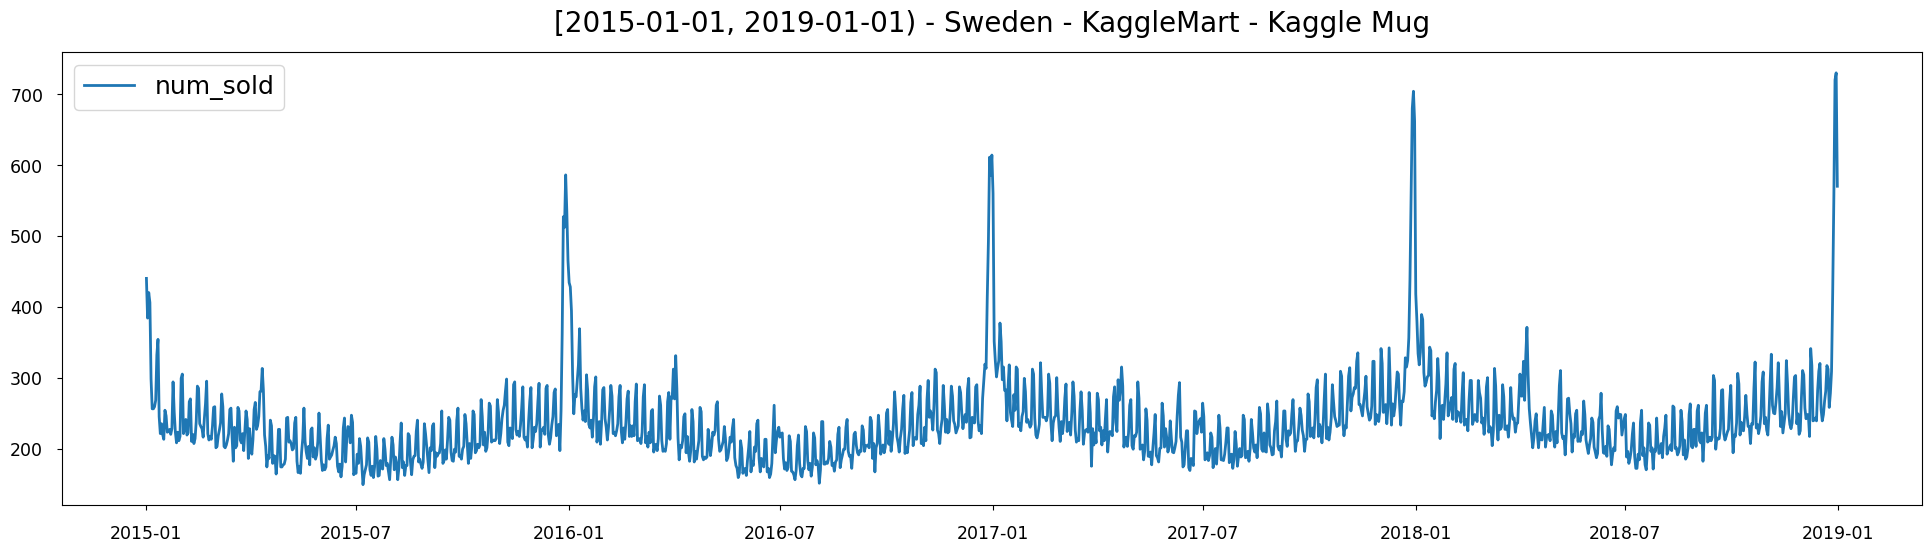

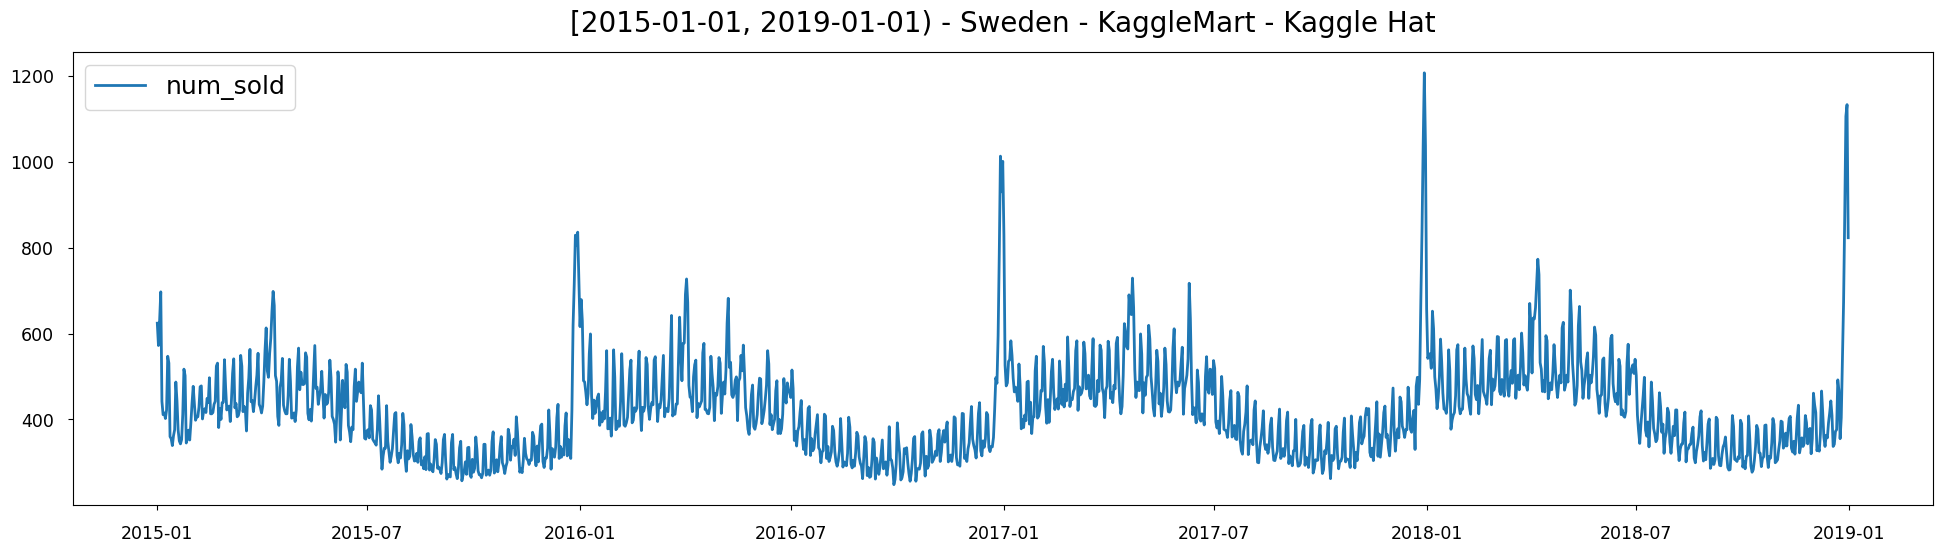

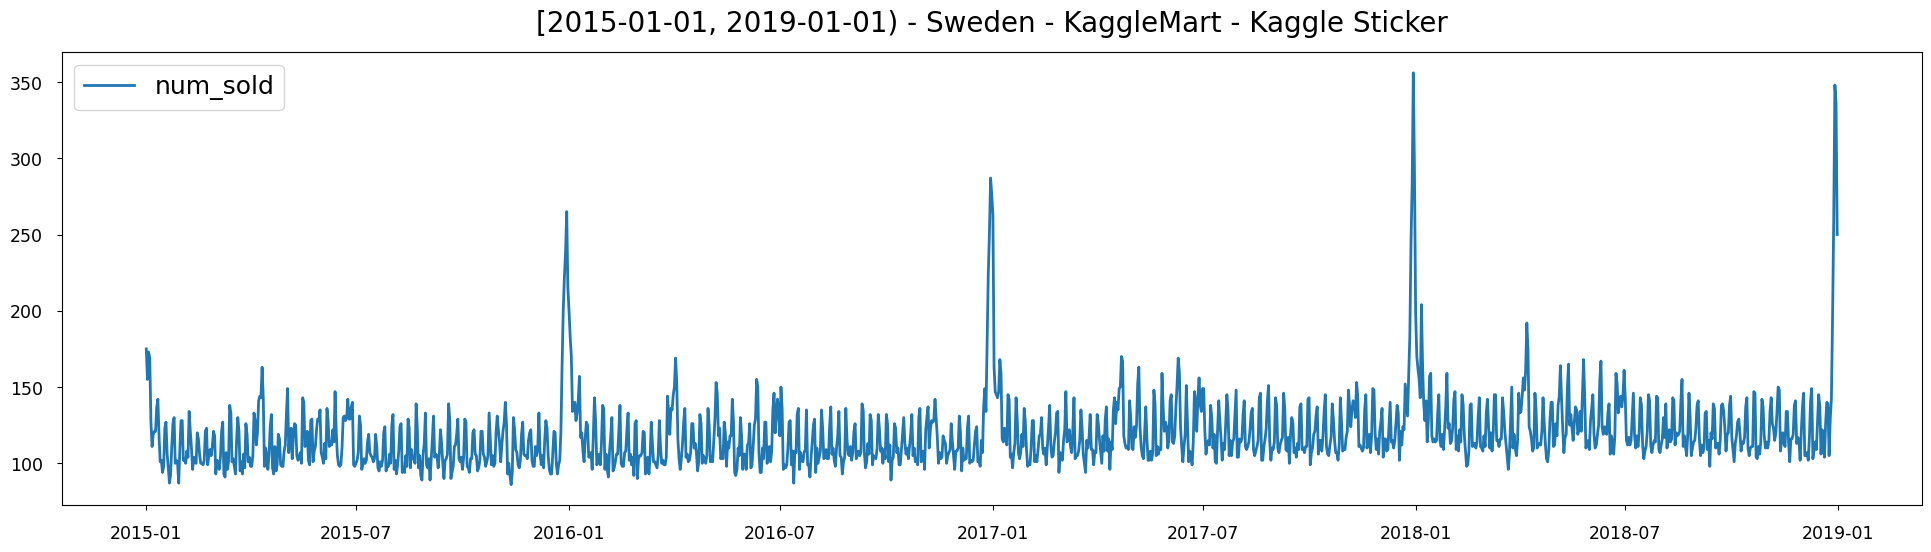

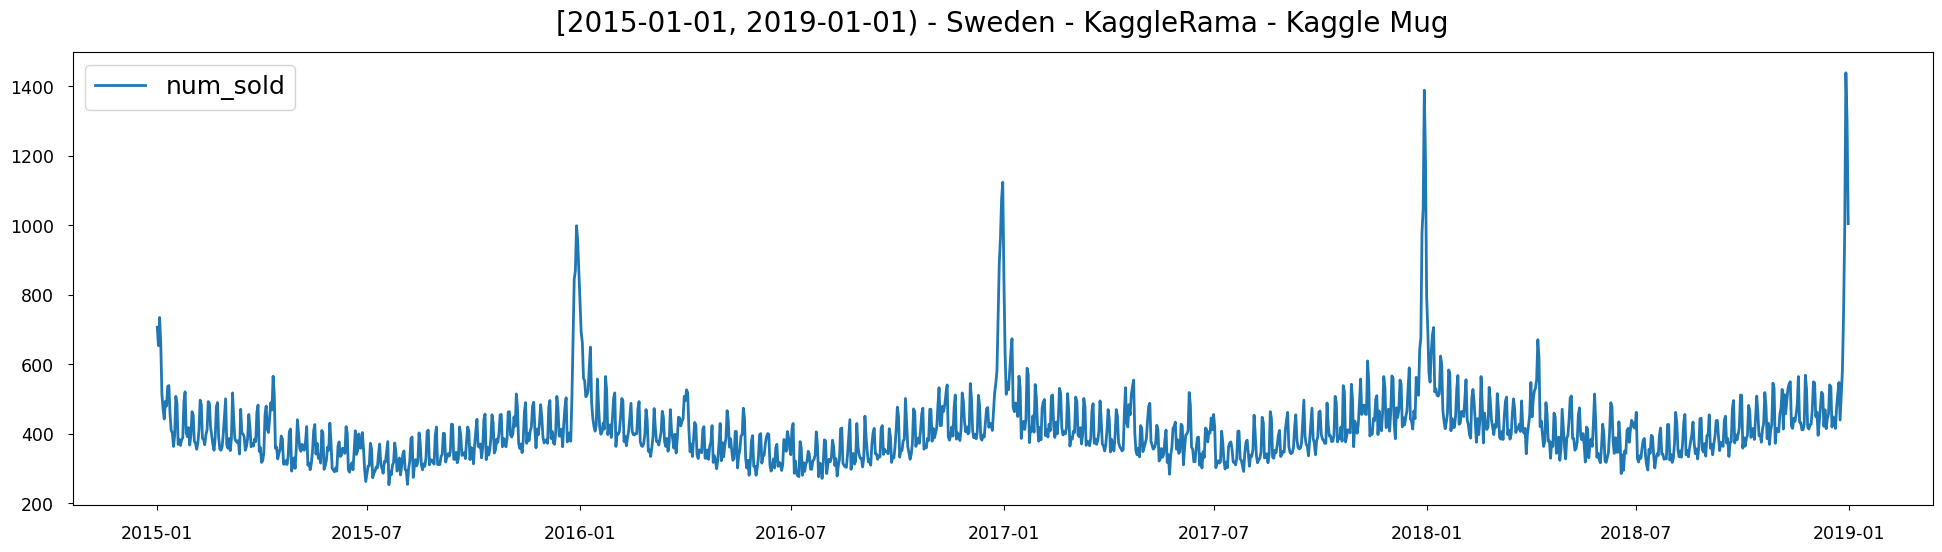

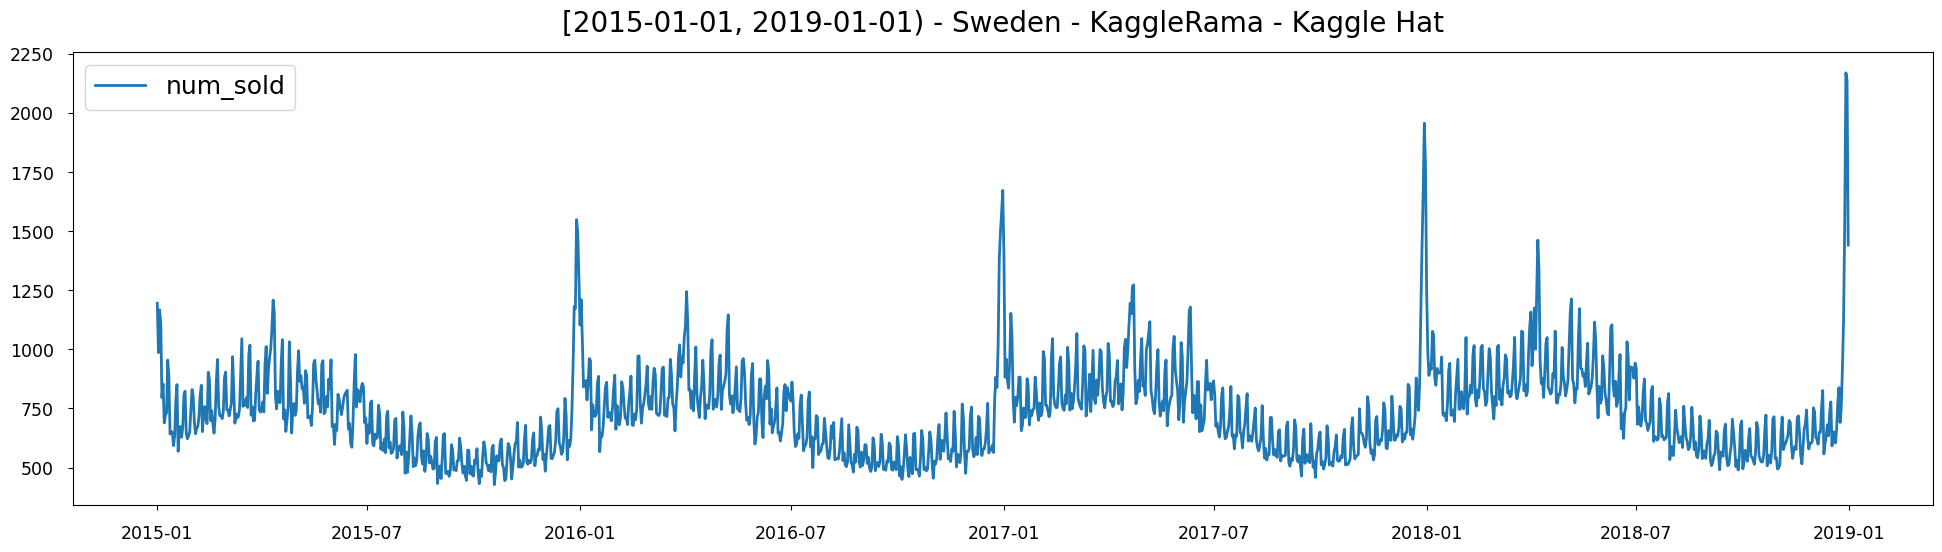

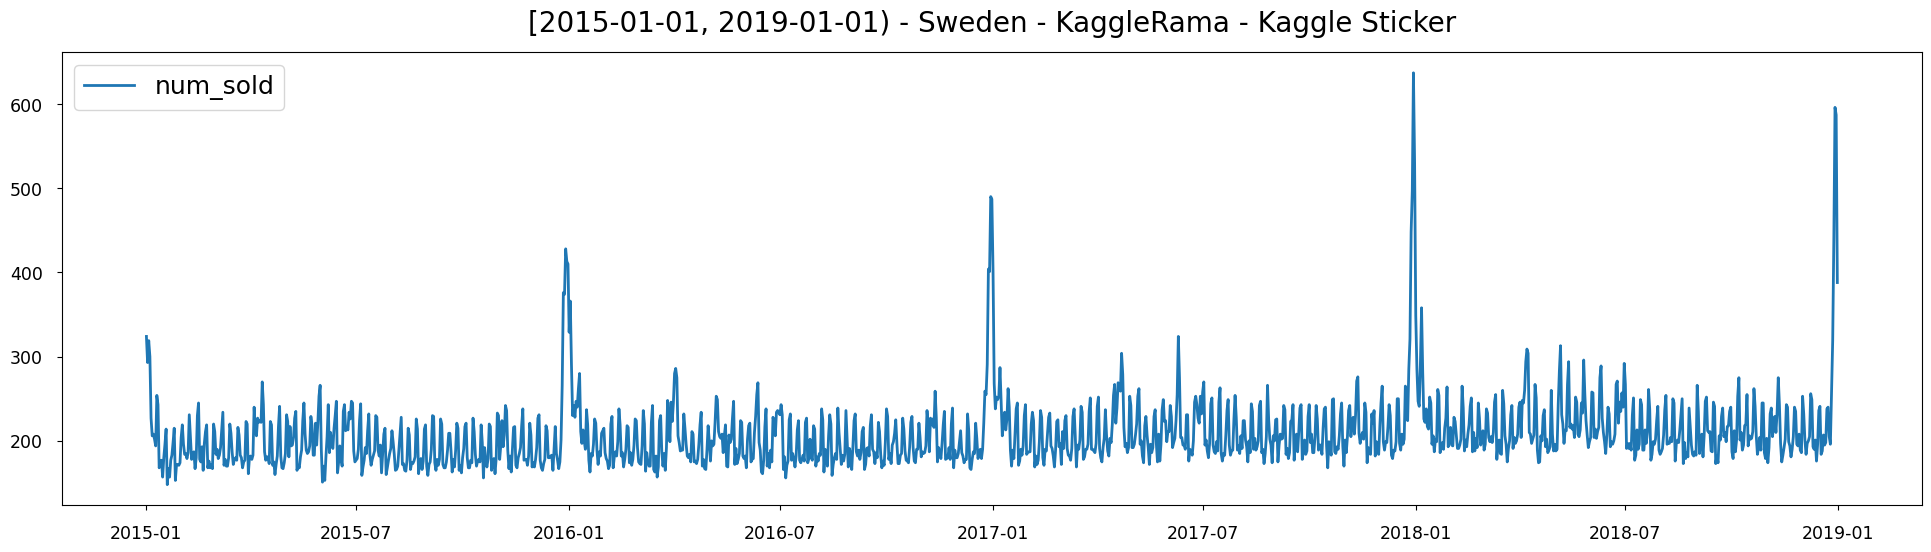

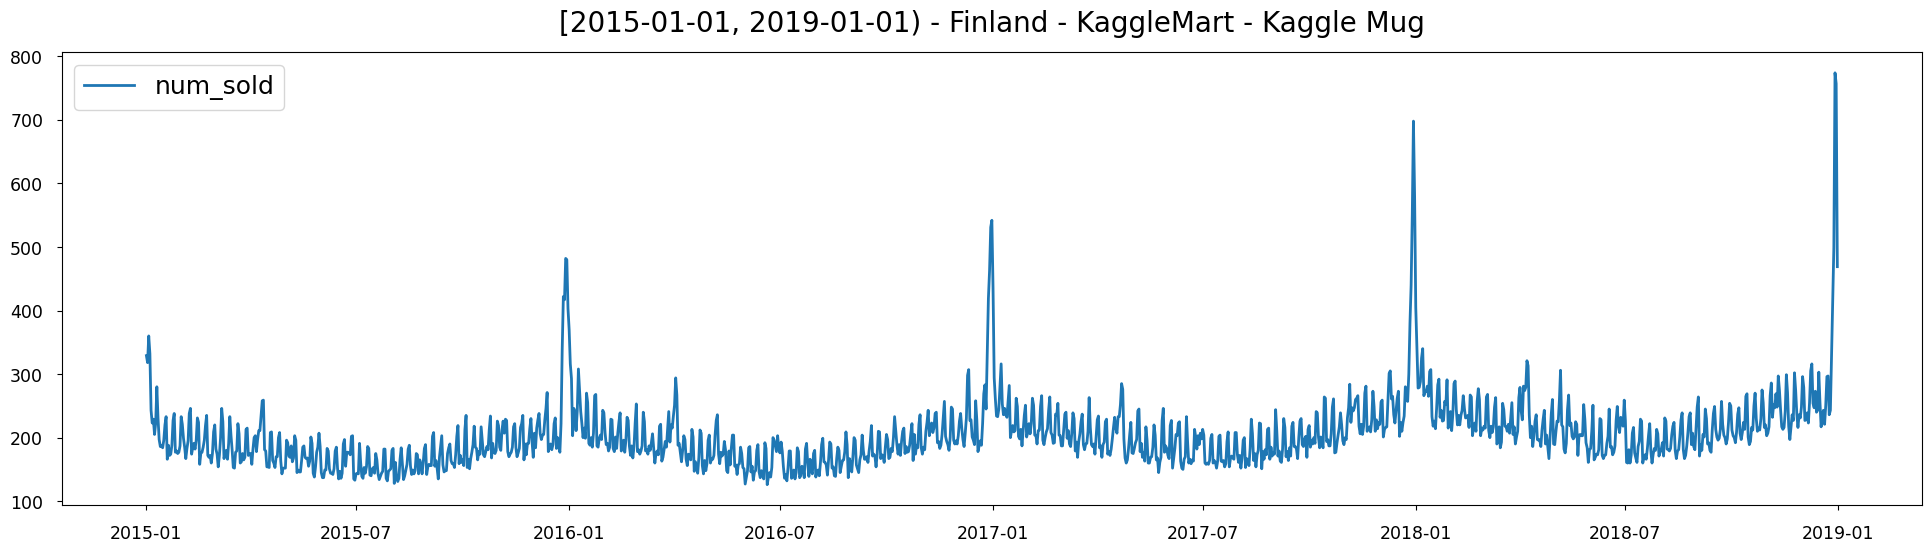

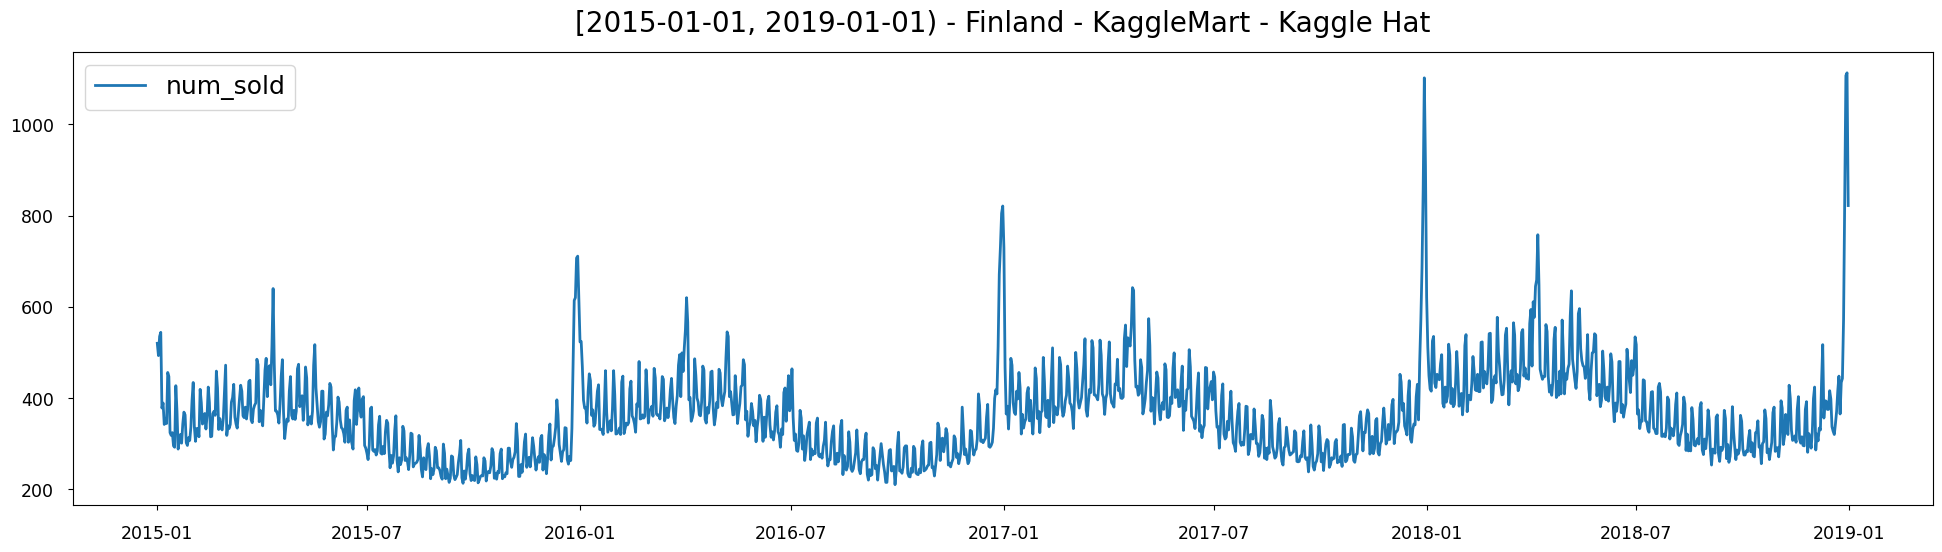

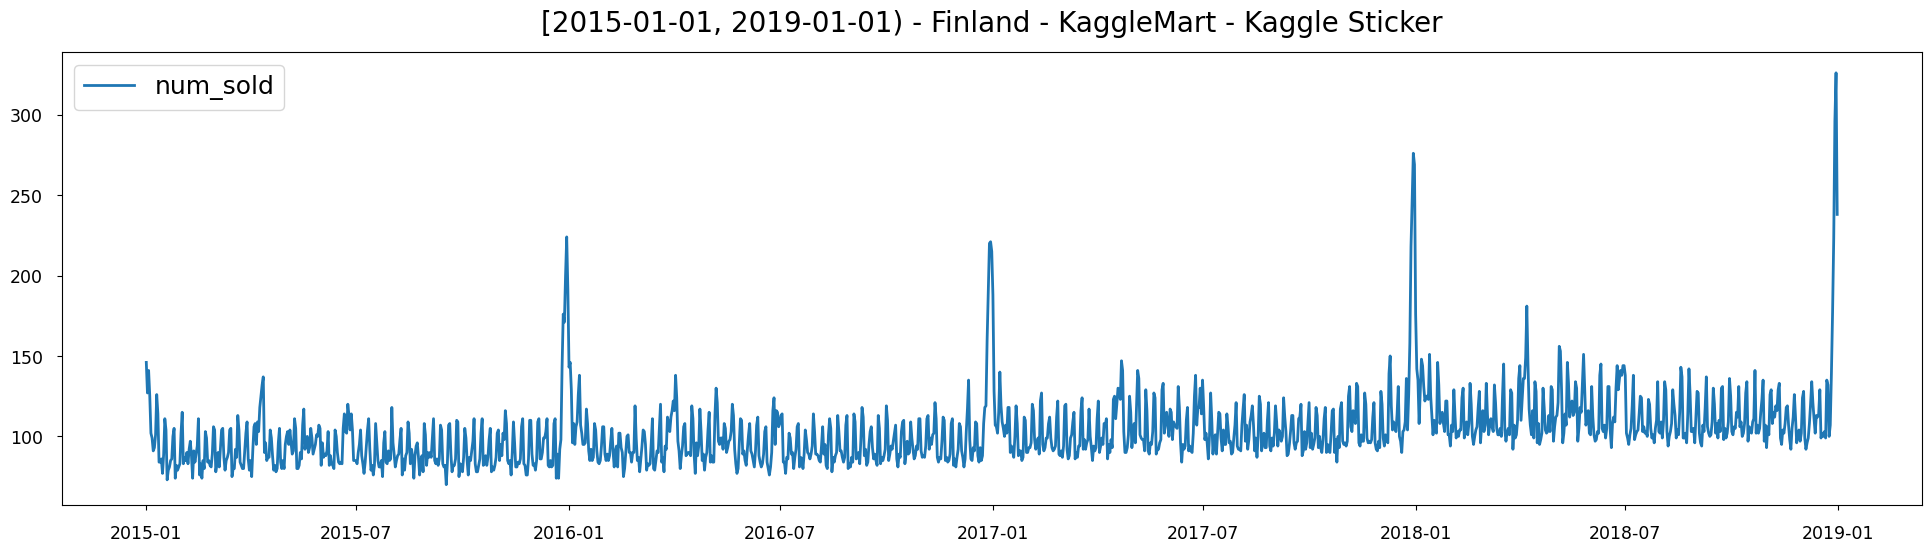

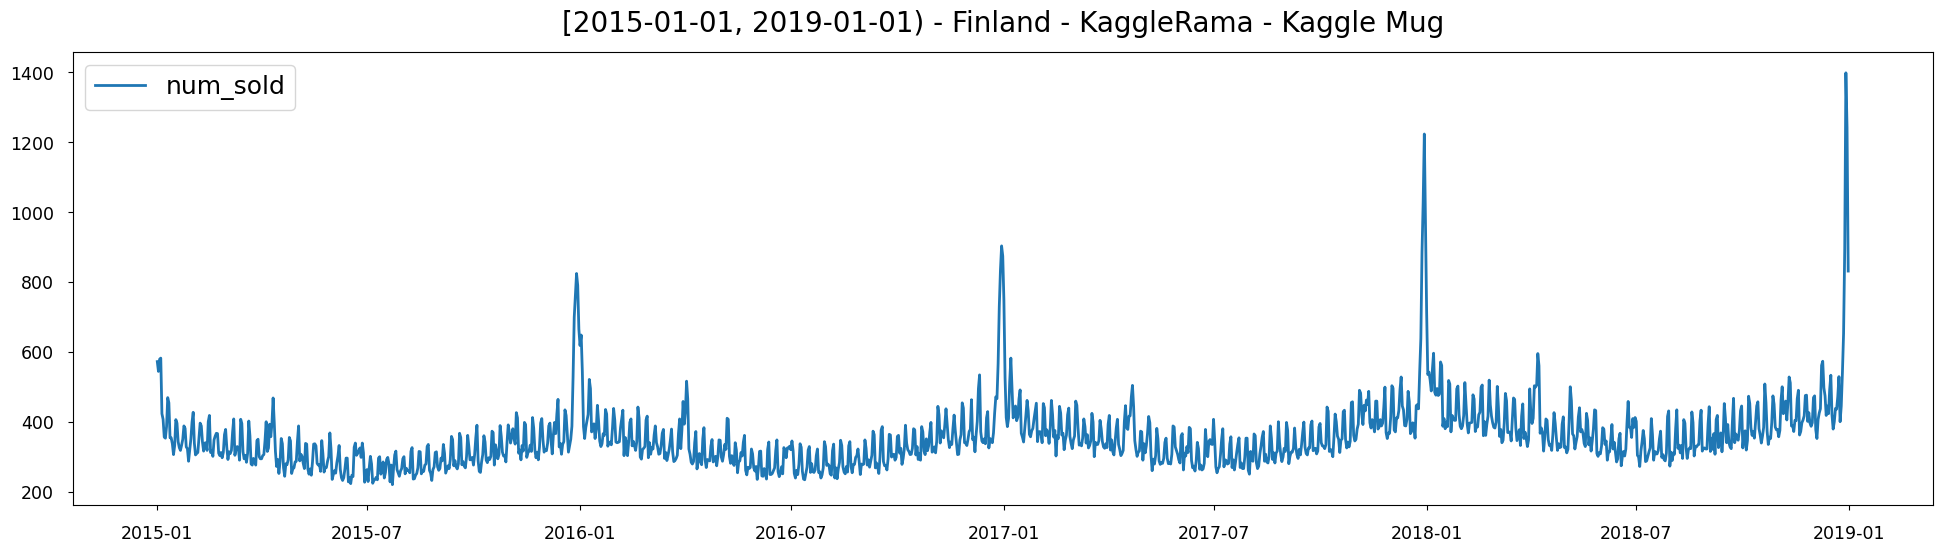

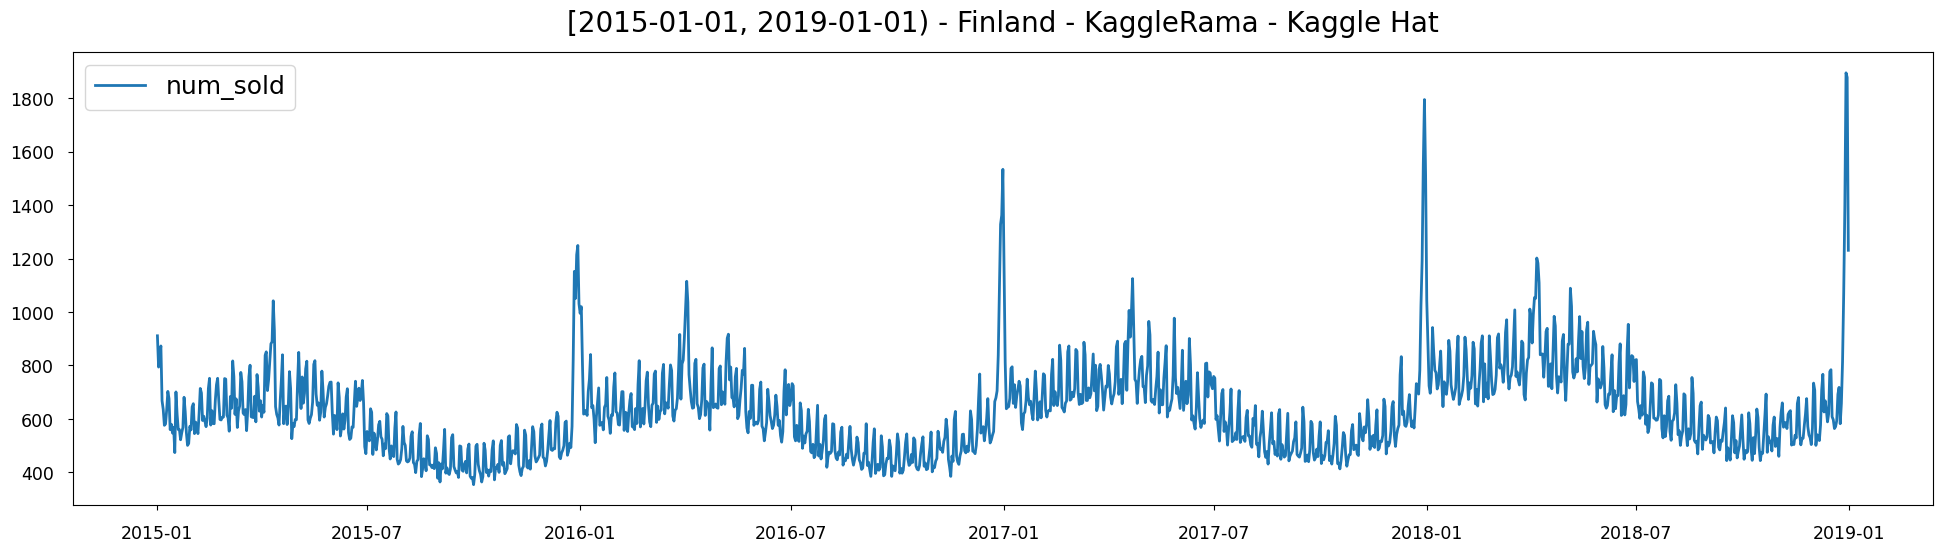

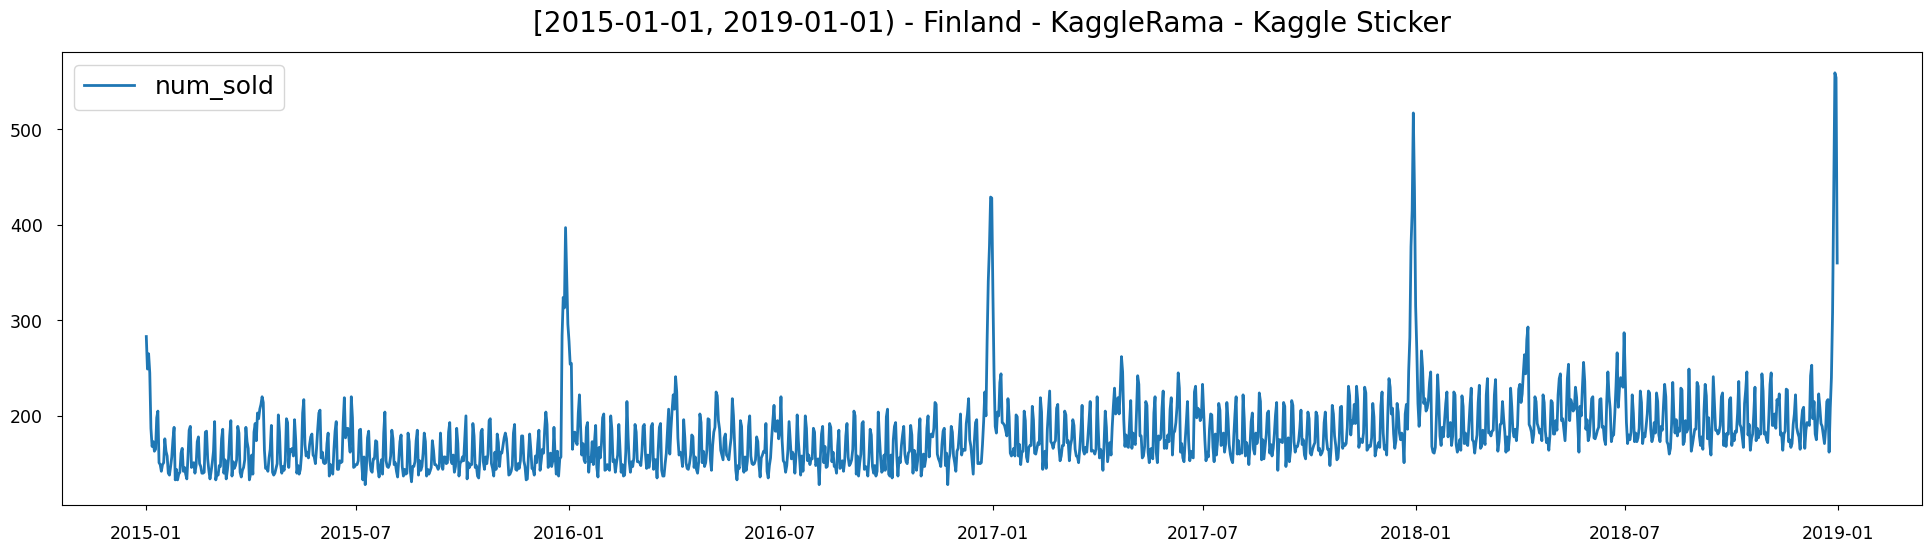

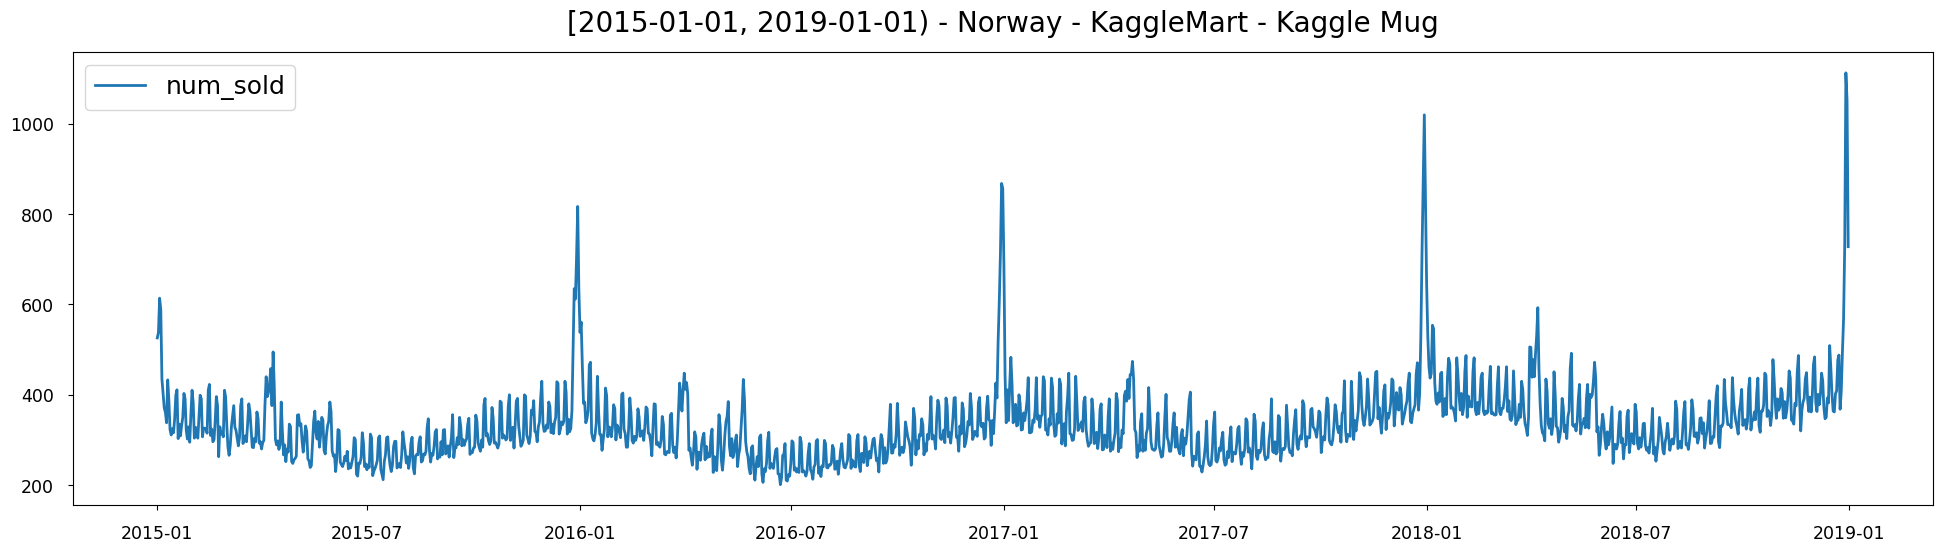

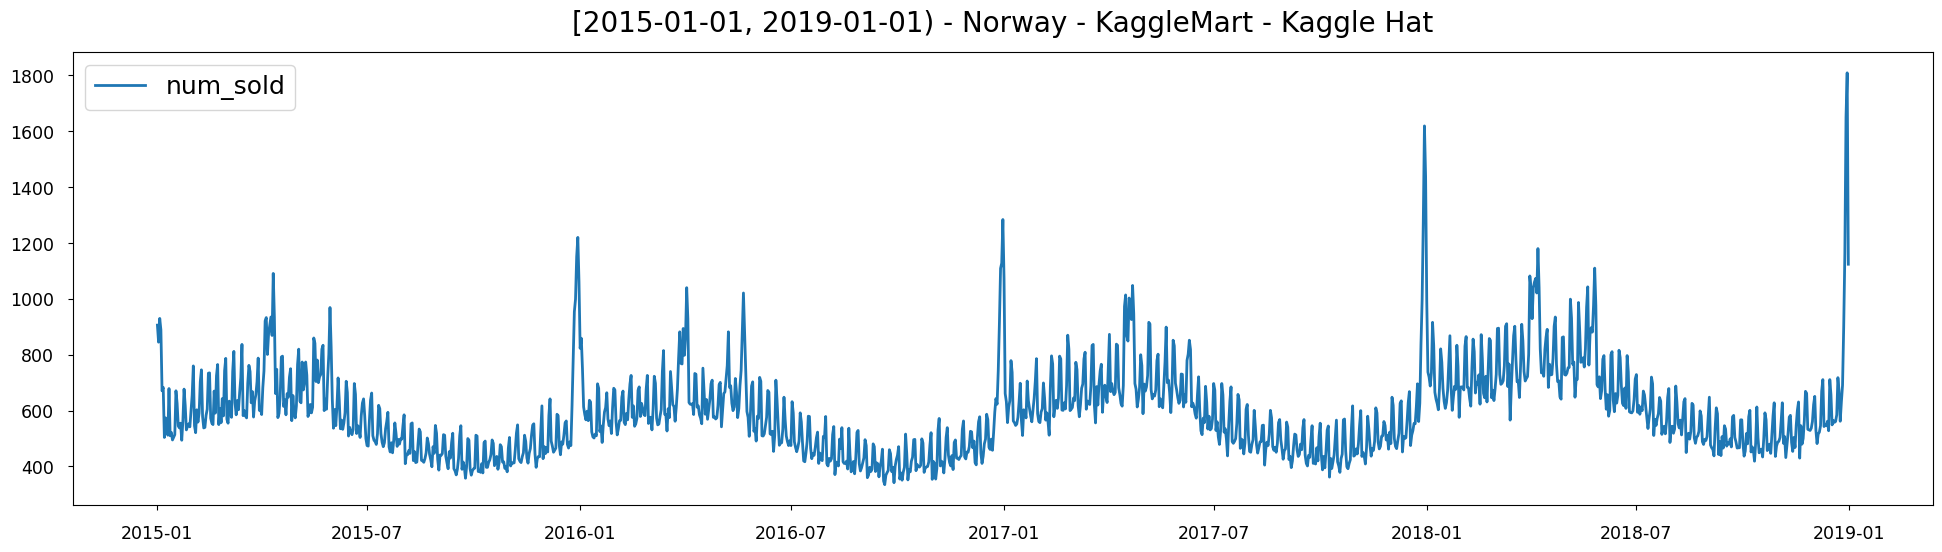

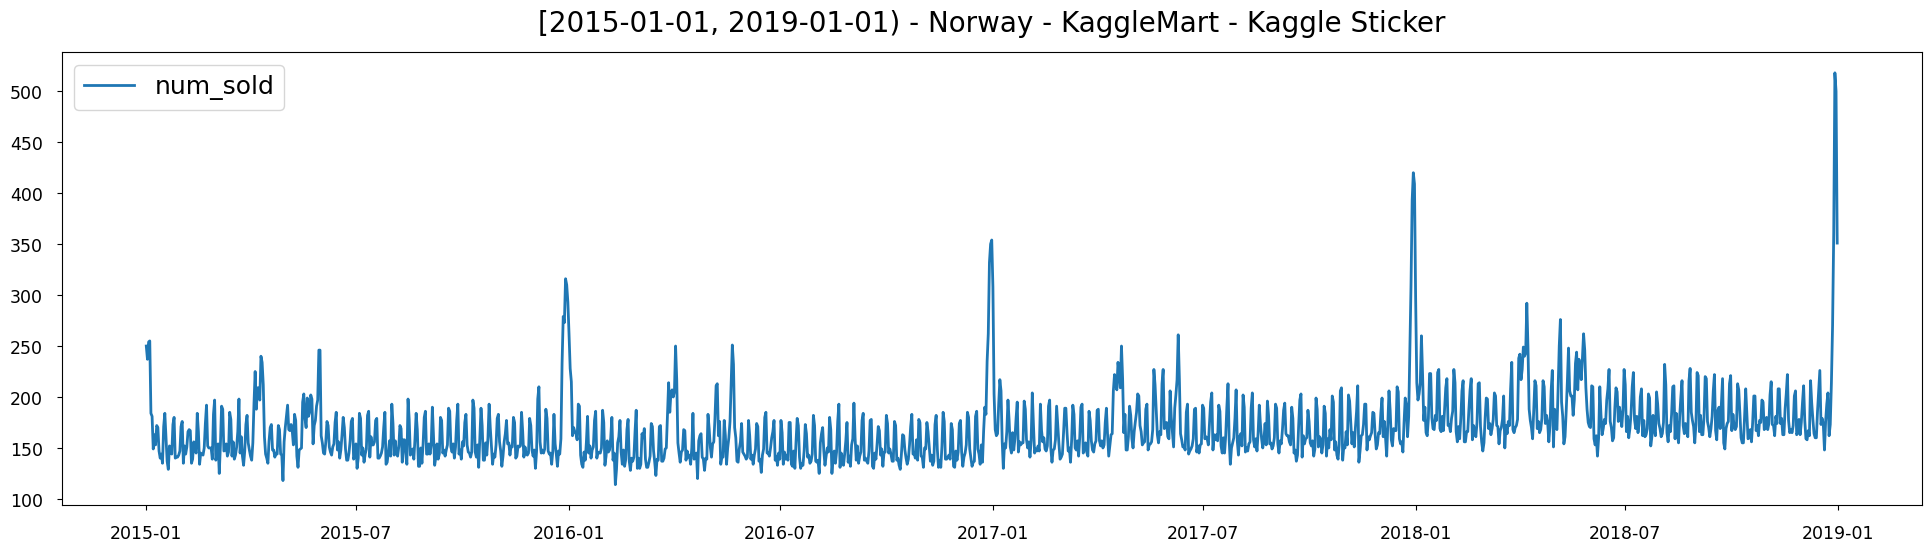

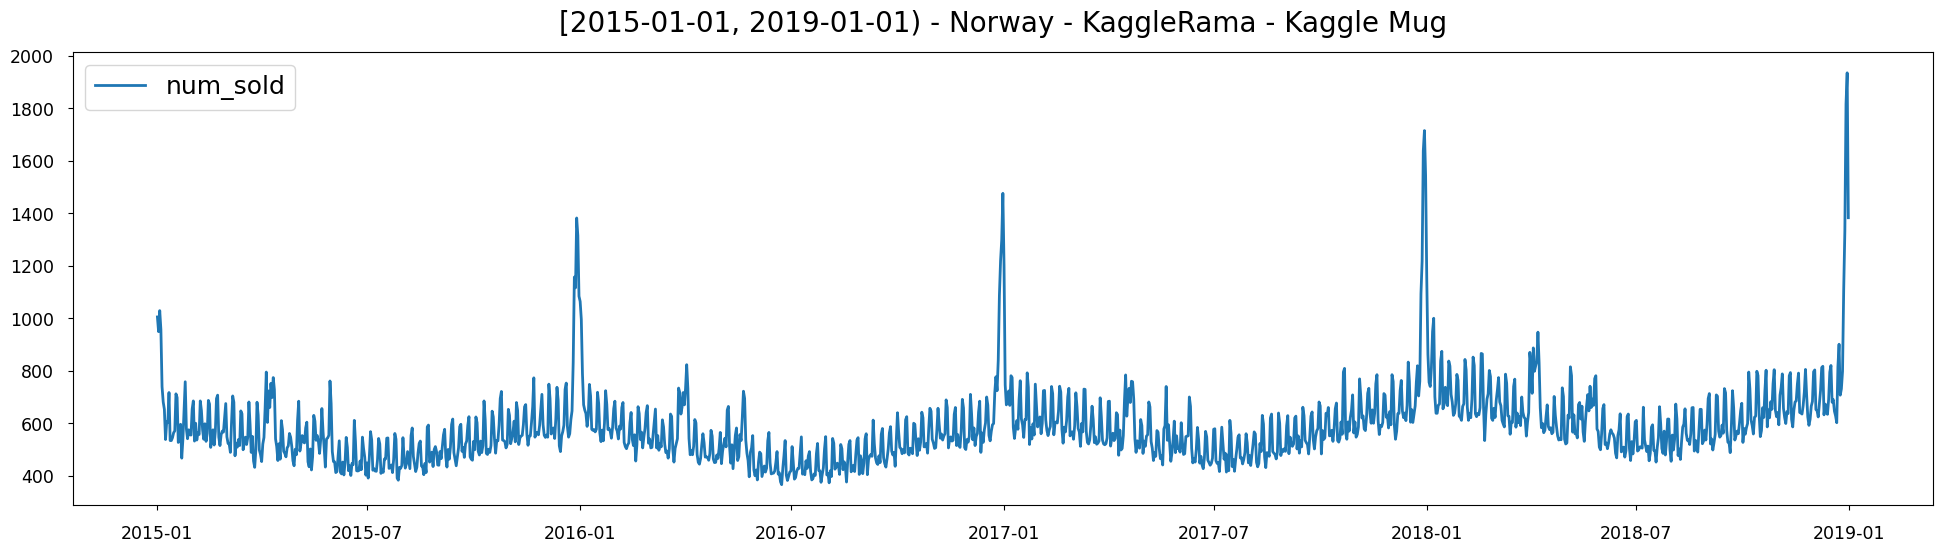

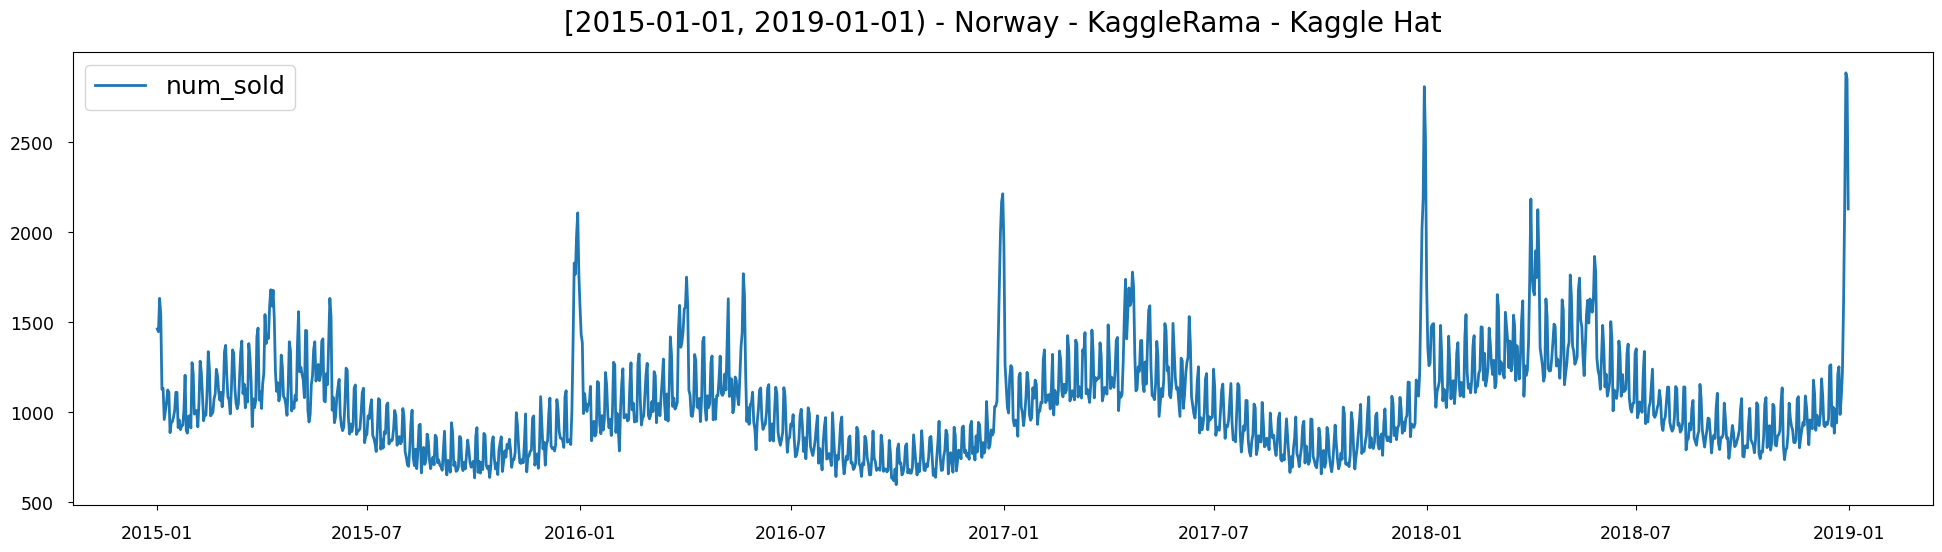

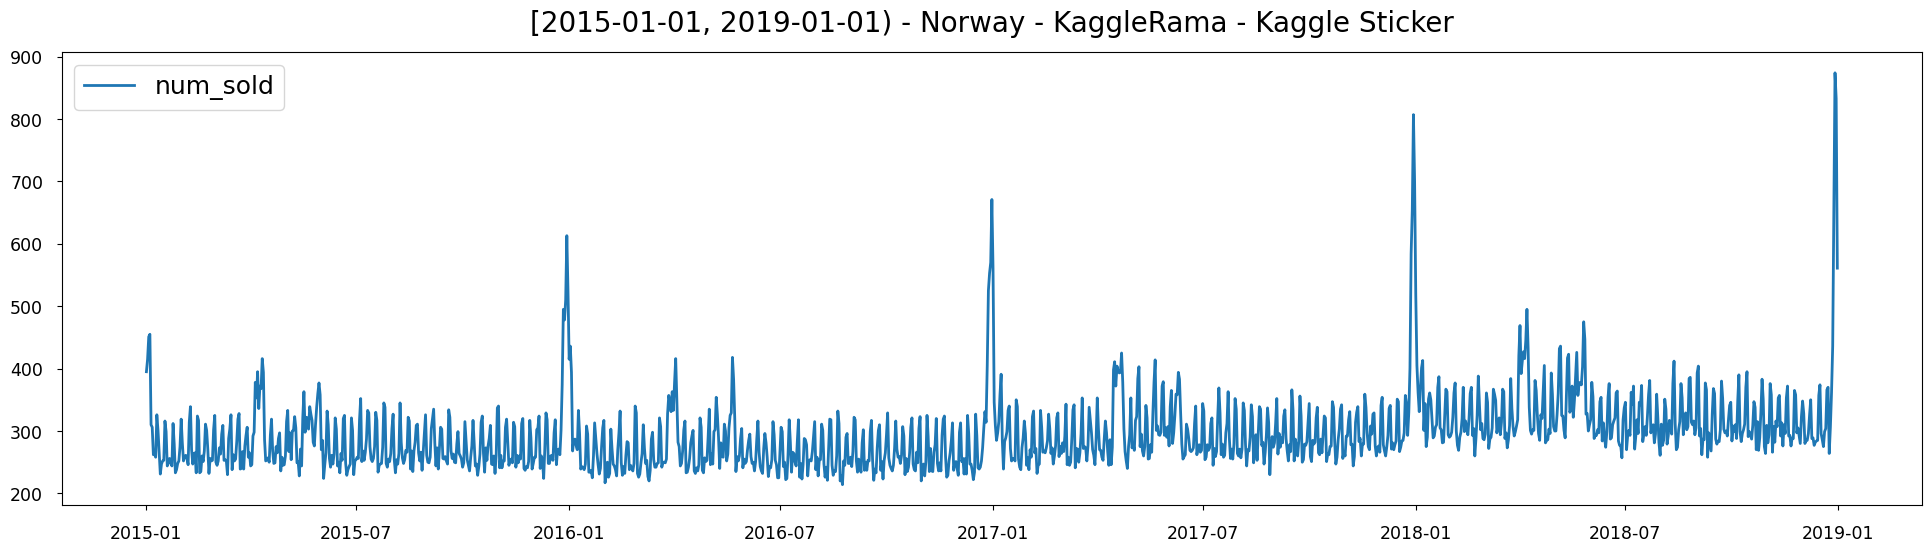

In [4]:
def visualize_ts(df, t, y, forecasts, start, end, country, store, product):
    
    idx = (df[t] >= start) & (df[t] < end) & (df['country'] == country) & (df['store'] == store) & (df['product'] == product)
    
    fig, ax = plt.subplots(figsize=(24, 6), dpi=100)
    ax.plot(df.loc[idx].set_index(t)[y], linewidth=2, label=y)
    if forecasts is not None:
        for forecast in forecasts:
            ax.plot(df.loc[idx].set_index(t)[forecast], linewidth=2, label=forecast)
    ax.tick_params(axis='x', labelsize=12.5, pad=10)
    ax.tick_params(axis='y', labelsize=12.5, pad=10)
    ax.set_title(f'[{start}, {end}) - {country} - {store} - {product}', size=20, pad=15)
    ax.legend(prop={'size': 18})
    plt.show()
    
    
for country in countries:
    for store in stores:
        for product in products:
            visualize_ts(
                df=df_train,
                t='date',
                y='num_sold',
                forecasts=None,
                start='2015-01-01',
                end='2019-01-01',
                country=country,
                store=store,
                product=product
            )

## 3. Holidays

The highest fluctuations can be seen on New Year's Day and Easter. The effect of New Year's Day is very short and strong but the effect Easter is weaker and longer.

In [5]:
new_year = pd.DataFrame({
  'holiday': 'new_year',
  'ds': pd.to_datetime(['2015-01-01', '2016-01-01', '2017-01-01', '2018-01-01', '2019-01-01']),
  'lower_window': -1,
  'upper_window': 0,
})

easter = pd.DataFrame({
  'holiday': 'easter',
  'ds': pd.to_datetime(['2015-04-05', '2016-03-27', '2017-04-16', '2018-04-01', '2019-04-21']),
  'lower_window': 0,
  'upper_window': 7,
})

holidays = pd.concat((new_year, easter))
holidays

holiday         ds  lower_window  upper_window
0  new_year 2015-01-01            -1             0
1  new_year 2016-01-01            -1             0
2  new_year 2017-01-01            -1             0
3  new_year 2018-01-01            -1             0
4  new_year 2019-01-01            -1             0
0    easter 2015-04-05             0             7
1    easter 2016-03-27             0             7
2    easter 2017-04-16             0             7
3    easter 2018-04-01             0             7
4    easter 2019-04-21             0             7

## 4. Metric

Submissions are evaluated on SMAPE (symmetric mean absolute percentage error) between forecasts and actual values. Advantages of using SMAPE are; it can interpreted as a percentage and it has lower (0%) and upper (200%) bounds.

In [6]:
def smape(y_true, y_pred):
    return 1 / len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)) * 100)

## 5. Prophet

In this section, Prophet is used for forecasting. [Prophet](https://facebook.github.io/prophet/) is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data.

Sales data between 2015-01-01 and 2018-01-01 are used as training set and sales data between 2018-01-01 and 2019-01-01 are used as validation set. Every country-store-product combination are modeled separately and forecasts are combined afterwards.

In [7]:
# Training period is between 2015-01-01 and 2018-01-01
# Validation period is between 2018-01-01 and 2019-01-01
folds = [
    ('2015-01-01', '2018-01-01'),
    ('2018-01-01', '2019-01-01'),
]

for country in countries:
    for store in stores:
        for product in products:
            for fold, (start, end) in enumerate(folds):
                # Skip iteration if it's the last fold
                if fold == len(folds) - 1:
                    continue
                    
                train_idx = (df_train['date'] >= start) &\
                            (df_train['date'] < end) &\
                            (df_train['country'] == country) &\
                            (df_train['store'] == store) &\
                            (df_train['product'] == product)
                train = df_train.loc[train_idx, ['date', 'num_sold']].reset_index(drop=True)
                train = train.rename(columns={'date': 'ds', 'num_sold': 'y'})
                val_idx = (df_train['date'] >= folds[fold + 1][0]) &\
                          (df_train['date'] < folds[fold + 1][1]) &\
                          (df_train['country'] == country) &\
                          (df_train['store'] == store) &\
                          (df_train['product'] == product)
                val = df_train.loc[val_idx, ['date', 'num_sold']].reset_index(drop=True)
                val = val.rename(columns={'date': 'ds', 'num_sold': 'y'})
                
                model = Prophet(
                    growth='linear',
                    holidays=holidays,
                    n_changepoints=10,
                    changepoint_range=0.4,
                    yearly_seasonality=True,
                    weekly_seasonality=True,
                    daily_seasonality=False,
                    seasonality_mode='additive',
                    seasonality_prior_scale=25,
                    holidays_prior_scale=100,
                    changepoint_prior_scale=0.01,
                    interval_width=0.5,
                    uncertainty_samples=False
                )
                model.fit(train)
                
                train_predictions = model.predict(train[['ds']])['yhat']
                val_predictions = model.predict(val[['ds']])['yhat']
                df_train.loc[val_idx, 'prophet_forecast'] =  val_predictions.values

                train_score = smape(train['y'].values, train_predictions.values)
                val_score = smape(val['y'].values, val_predictions.values)
                print(f'\nTraining Range [{start}, {end}) - {country} - {store} - {product} - Train SMAPE: {train_score:4f}')
                print(f'Validation Range [{folds[fold + 1][0]}, {folds[fold + 1][1]}) - {country} - {store} - {product} - Validation SMAPE: {val_score:4f}\n')
                
                test_idx = (df_test['country'] == country) &\
                           (df_test['store'] == store) &\
                           (df_test['product'] == product)
                test = df_test.loc[test_idx, ['date']].reset_index(drop=True)
                test = test.rename(columns={'date': 'ds'})
                test_predictions = model.predict(test[['ds']])['yhat']
                df_test.loc[test_idx, 'prophet_forecast'] = test_predictions.values


Initial log joint probability = -121.684
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      65       2956.23    0.00118736       694.707   2.697e-06       0.001      125  LS failed, Hessian reset 
      99       2957.37   8.75721e-06       258.572      0.3888           1      180   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       2957.37   3.25052e-06       294.862   1.363e-08       0.001      227  LS failed, Hessian reset 
     199       2957.69   5.10929e-05       241.607       1.643           1      361   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     275       2957.72    8.4675e-09       237.145     0.06697           1      482   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance

Training Range [2015-01-01, 2018-01-01) - Sweden - KaggleMart - Kaggle Mug - Train SMAPE: 6.42

## 6. Neural Prophet

In this section, Neural Prophet is used for forecasting. [Neural Prophet](https://neuralprophet.com/html/contents.html) has a number of added features with respect to original Prophet. They are as follows.

* Gradient Descent for optimisation via using PyTorch as the backend
* Modelling autocorrelation of time series using AR-Net
* Modelling lagged regressors using a sepearate Feed-Forward Neural Network
* Configurable non-linear deep layers of the FFNNs
* Tuneable to specific forecast horizons (greater than 1)
* Custom losses and metrics

Sales data between 2015-01-01 and 2018-01-01 are used as training set and sales data between 2018-01-01 and 2019-01-01 are used as validation set. Every country-store-product combination are modeled separately and forecasts are combined afterwards.

In [8]:
# Training period is between 2015-01-01 and 2018-01-01
# Validation period is between 2018-01-01 and 2019-01-01
folds = [
    ('2015-01-01', '2018-01-01'),
    ('2018-01-01', '2019-01-01'),
]

# Neural Prophet requires holidays to be in one-hot encoded format on all timesteps
events = pd.concat((holidays['ds'], pd.get_dummies(holidays['holiday'])), axis=1)

for country in countries:
    for store in stores:
        for product in products:
            for fold, (start, end) in enumerate(folds):
                # Skip iteration if it's the last fold
                if fold == len(folds) - 1:
                    continue
                    
                train_idx = (df_train['date'] >= start) &\
                            (df_train['date'] < end) &\
                            (df_train['country'] == country) &\
                            (df_train['store'] == store) &\
                            (df_train['product'] == product)
                train = df_train.loc[train_idx, ['date', 'num_sold']].reset_index(drop=True)
                train = train.rename(columns={'date': 'ds', 'num_sold': 'y'})
                train = train.merge(events, on='ds', how='left').fillna(0)
                train['easter'] = train['easter'].astype(np.uint8)
                train['new_year'] = train['new_year'].astype(np.uint8)
                val_idx = (df_train['date'] >= folds[fold + 1][0]) &\
                          (df_train['date'] < folds[fold + 1][1]) &\
                          (df_train['country'] == country) &\
                          (df_train['store'] == store) &\
                          (df_train['product'] == product)
                val = df_train.loc[val_idx, ['date', 'num_sold']].reset_index(drop=True)
                val = val.rename(columns={'date': 'ds', 'num_sold': 'y'})
                val = val.merge(events, on='ds', how='left').fillna(0)
                val['easter'] = val['easter'].astype(np.uint8)
                val['new_year'] = val['new_year'].astype(np.uint8)
                
                model = NeuralProphet(
                    growth='linear',
                    n_changepoints=10,
                    changepoints_range=0.4,
                    trend_reg=1,
                    trend_reg_threshold=False,
                    yearly_seasonality=True,
                    weekly_seasonality=True,
                    daily_seasonality=False,
                    seasonality_mode='additive',
                    seasonality_reg=1,
                    n_forecasts=365,
                    normalize='off'
                )
                model = model.add_events(['new_year'], mode='multiplicative', lower_window=-1)
                model = model.add_events(['easter'], mode='additive', upper_window=7)
                model.fit(train, freq='D')
                
                train_predictions = model.predict(train)['yhat1']
                val_predictions = model.predict(val)['yhat1']
                df_train.loc[val_idx, 'neural_prophet_forecast'] =  val_predictions.values

                train_score = smape(train['y'].values, train_predictions.values)
                val_score = smape(val['y'].values, val_predictions.values)
                print(f'\nTraining Range [{start}, {end}) - {country} - {store} - {product} - Train SMAPE: {train_score:4f}')
                print(f'Validation Range [{folds[fold + 1][0]}, {folds[fold + 1][1]}) - {country} - {store} - {product} - Validation SMAPE: {val_score:4f}\n')
                
                test_idx = (df_test['country'] == country) &\
                           (df_test['store'] == store) &\
                           (df_test['product'] == product)
                test = df_test.loc[test_idx, ['date']].reset_index(drop=True)
                test = test.rename(columns={'date': 'ds'})
                test['y'] = np.nan
                test = test.merge(events, on='ds', how='left').fillna(0)
                test['easter'] = test['easter'].astype(np.uint8)
                test['new_year'] = test['new_year'].astype(np.uint8)
                test_predictions = model.predict(test)['yhat1']
                df_test.loc[test_idx, 'neural_prophet_forecast'] = test_predictions.values


WARNING - (NP.forecaster.__init__) - Changing n_forecasts to 1. Without lags, the forecast can be computed for any future time, independent of lagged values
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 176


  0%|          | 0/252 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.08E+01, min: 6.62E+01


  0%|          | 0/252 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.26E+01, min: 6.09E+01


  0%|          | 0/252 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.90E+00, min: 5.61E+01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 9.64E+00
Epoch[176/176]: 100%|██████████| 176/176 [00:12<00:00, 13.94it/s, SmoothL1Loss=16.3, MAE=16.8, RMSE=30.3, RegLoss=0.358]
WARNING - (NP.forecaster.__init__) - Changing n_forecasts to 1. Without lags, the forecast can be computed for any future time, independent of lagged values
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 176


  0%|          | 0/252 [00:00<?, ?it/s]


Training Range [2015-01-01, 2018-01-01) - Sweden - KaggleMart - Kaggle Mug - Train SMAPE: 6.612345
Validation Range [2018-01-01, 2019-01-01) - Sweden - KaggleMart - Kaggle Mug - Validation SMAPE: 6.187900



INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.03E+01, min: 6.62E+01


  0%|          | 0/252 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.42E+01, min: 6.62E+01


  0%|          | 0/252 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.42E+01, min: 6.62E+01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 3.61E+01
Epoch[176/176]: 100%|██████████| 176/176 [00:12<00:00, 13.87it/s, SmoothL1Loss=30.6, MAE=31.1, RMSE=54.5, RegLoss=0.668]
WARNING - (NP.forecaster.__init__) - Changing n_forecasts to 1. Without lags, the forecast can be computed for any future time, independent of lagged values
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 176


  0%|          | 0/252 [00:00<?, ?it/s]


Training Range [2015-01-01, 2018-01-01) - Sweden - KaggleMart - Kaggle Hat - Train SMAPE: 6.998382
Validation Range [2018-01-01, 2019-01-01) - Sweden - KaggleMart - Kaggle Hat - Validation SMAPE: 6.237910



INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 9.04E-01, min: 4.76E+01


  0%|          | 0/252 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 9.04E-01, min: 3.42E+01


  0%|          | 0/252 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 9.04E-01, min: 4.38E+01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 9.04E-01
Epoch[176/176]: 100%|██████████| 176/176 [00:12<00:00, 13.85it/s, SmoothL1Loss=7.53, MAE=8.01, RMSE=13.9, RegLoss=0.17]
WARNING - (NP.forecaster.__init__) - Changing n_forecasts to 1. Without lags, the forecast can be computed for any future time, independent of lagged values
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 176


  0%|          | 0/252 [00:00<?, ?it/s]


Training Range [2015-01-01, 2018-01-01) - Sweden - KaggleMart - Kaggle Sticker - Train SMAPE: 6.369792
Validation Range [2018-01-01, 2019-01-01) - Sweden - KaggleMart - Kaggle Sticker - Validation SMAPE: 6.175014



INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.12E+00, min: 5.56E+00


  0%|          | 0/252 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.12E+00, min: 5.56E+00


  0%|          | 0/252 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.42E+01, min: 6.04E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 6.93E+00
Epoch[176/176]: 100%|██████████| 176/176 [00:12<00:00, 13.96it/s, SmoothL1Loss=28.9, MAE=29.3, RMSE=55, RegLoss=0.648]
WARNING - (NP.forecaster.__init__) - Changing n_forecasts to 1. Without lags, the forecast can be computed for any future time, independent of lagged values
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 176


  0%|          | 0/252 [00:00<?, ?it/s]


Training Range [2015-01-01, 2018-01-01) - Sweden - KaggleRama - Kaggle Mug - Train SMAPE: 6.660934
Validation Range [2018-01-01, 2019-01-01) - Sweden - KaggleRama - Kaggle Mug - Validation SMAPE: 6.636019



INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.71E+00, min: 1.17E+01


  0%|          | 0/252 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.12E+00, min: 1.08E+01


  0%|          | 0/252 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.12E+00, min: 1.17E+01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 4.98E+00
Epoch[176/176]: 100%|██████████| 176/176 [00:12<00:00, 13.85it/s, SmoothL1Loss=54.6, MAE=55.1, RMSE=91.5, RegLoss=1.27]
WARNING - (NP.forecaster.__init__) - Changing n_forecasts to 1. Without lags, the forecast can be computed for any future time, independent of lagged values
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 176


  0%|          | 0/252 [00:00<?, ?it/s]


Training Range [2015-01-01, 2018-01-01) - Sweden - KaggleRama - Kaggle Hat - Train SMAPE: 7.209630
Validation Range [2018-01-01, 2019-01-01) - Sweden - KaggleRama - Kaggle Hat - Validation SMAPE: 6.674333



INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.92E+01, min: 6.62E+01


  0%|          | 0/252 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.61E+00, min: 6.62E+01


  0%|          | 0/252 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.61E+00, min: 4.76E+01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 3.68E+00
Epoch[176/176]: 100%|██████████| 176/176 [00:12<00:00, 13.81it/s, SmoothL1Loss=13.6, MAE=14, RMSE=24.6, RegLoss=0.283]
WARNING - (NP.forecaster.__init__) - Changing n_forecasts to 1. Without lags, the forecast can be computed for any future time, independent of lagged values
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 176


  0%|          | 0/252 [00:00<?, ?it/s]


Training Range [2015-01-01, 2018-01-01) - Sweden - KaggleRama - Kaggle Sticker - Train SMAPE: 6.432610
Validation Range [2018-01-01, 2019-01-01) - Sweden - KaggleRama - Kaggle Sticker - Validation SMAPE: 6.310862



INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.61E+00, min: 5.17E+01


  0%|          | 0/252 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.50E+01, min: 6.62E+01


  0%|          | 0/252 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.48E+00, min: 6.62E+01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 3.30E+00
Epoch[176/176]: 100%|██████████| 176/176 [00:12<00:00, 13.79it/s, SmoothL1Loss=13.6, MAE=14.1, RMSE=26.6, RegLoss=0.345]
WARNING - (NP.forecaster.__init__) - Changing n_forecasts to 1. Without lags, the forecast can be computed for any future time, independent of lagged values
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 176


  0%|          | 0/252 [00:00<?, ?it/s]


Training Range [2015-01-01, 2018-01-01) - Finland - KaggleMart - Kaggle Mug - Train SMAPE: 6.611415
Validation Range [2018-01-01, 2019-01-01) - Finland - KaggleMart - Kaggle Mug - Validation SMAPE: 8.190618



INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.43E+00, min: 6.62E+01


  0%|          | 0/252 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.90E+01, min: 6.62E+01


  0%|          | 0/252 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.90E+01, min: 6.62E+01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.27E+01
Epoch[176/176]: 100%|██████████| 176/176 [00:12<00:00, 13.93it/s, SmoothL1Loss=24.2, MAE=24.7, RMSE=43.8, RegLoss=0.562]
WARNING - (NP.forecaster.__init__) - Changing n_forecasts to 1. Without lags, the forecast can be computed for any future time, independent of lagged values
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 176


  0%|          | 0/252 [00:00<?, ?it/s]


Training Range [2015-01-01, 2018-01-01) - Finland - KaggleMart - Kaggle Hat - Train SMAPE: 6.617865
Validation Range [2018-01-01, 2019-01-01) - Finland - KaggleMart - Kaggle Hat - Validation SMAPE: 8.128779



INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.40E+00, min: 4.38E+01


  0%|          | 0/252 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.08E+01, min: 3.71E+01


  0%|          | 0/252 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 9.12E+00, min: 4.38E+01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 9.38E+00
Epoch[176/176]: 100%|██████████| 176/176 [00:12<00:00, 13.94it/s, SmoothL1Loss=6.06, MAE=6.54, RMSE=11.2, RegLoss=0.13]
WARNING - (NP.forecaster.__init__) - Changing n_forecasts to 1. Without lags, the forecast can be computed for any future time, independent of lagged values
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 176



Training Range [2015-01-01, 2018-01-01) - Finland - KaggleMart - Kaggle Sticker - Train SMAPE: 6.179362
Validation Range [2018-01-01, 2019-01-01) - Finland - KaggleMart - Kaggle Sticker - Validation SMAPE: 7.765177



  0%|          | 0/252 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.64E+00, min: 6.62E+01


  0%|          | 0/252 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.64E+00, min: 6.62E+01


  0%|          | 0/252 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.64E+00, min: 6.62E+01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 2.64E+00
Epoch[176/176]: 100%|██████████| 176/176 [00:12<00:00, 13.92it/s, SmoothL1Loss=23.7, MAE=24.2, RMSE=45.7, RegLoss=0.571]
WARNING - (NP.forecaster.__init__) - Changing n_forecasts to 1. Without lags, the forecast can be computed for any future time, independent of lagged values
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 176


  0%|          | 0/252 [00:00<?, ?it/s]


Training Range [2015-01-01, 2018-01-01) - Finland - KaggleRama - Kaggle Mug - Train SMAPE: 6.449557
Validation Range [2018-01-01, 2019-01-01) - Finland - KaggleRama - Kaggle Mug - Validation SMAPE: 8.138998



INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.34E+00, min: 6.62E+01


  0%|          | 0/252 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.34E+00, min: 9.12E+00


  0%|          | 0/252 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.34E+00, min: 9.91E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 4.34E+00
Epoch[176/176]: 100%|██████████| 176/176 [00:12<00:00, 13.99it/s, SmoothL1Loss=43.4, MAE=43.9, RMSE=75.2, RegLoss=1.08]
WARNING - (NP.forecaster.__init__) - Changing n_forecasts to 1. Without lags, the forecast can be computed for any future time, independent of lagged values
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 176


  0%|          | 0/252 [00:00<?, ?it/s]


Training Range [2015-01-01, 2018-01-01) - Finland - KaggleRama - Kaggle Hat - Train SMAPE: 6.800457
Validation Range [2018-01-01, 2019-01-01) - Finland - KaggleRama - Kaggle Hat - Validation SMAPE: 7.942369



INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.50E+01, min: 5.17E+01


  0%|          | 0/252 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.63E+01, min: 6.62E+01


  0%|          | 0/252 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.37E+00, min: 5.17E+01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 6.93E+00
Epoch[176/176]: 100%|██████████| 176/176 [00:12<00:00, 13.86it/s, SmoothL1Loss=11.6, MAE=12.1, RMSE=21.2, RegLoss=0.269]
WARNING - (NP.forecaster.__init__) - Changing n_forecasts to 1. Without lags, the forecast can be computed for any future time, independent of lagged values
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 176


  0%|          | 0/252 [00:00<?, ?it/s]


Training Range [2015-01-01, 2018-01-01) - Finland - KaggleRama - Kaggle Sticker - Train SMAPE: 6.505877
Validation Range [2018-01-01, 2019-01-01) - Finland - KaggleRama - Kaggle Sticker - Validation SMAPE: 7.364028



INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.43E+00, min: 6.62E+01


  0%|          | 0/252 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.46E+01, min: 6.62E+01


  0%|          | 0/252 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.43E+00, min: 6.62E+01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 5.26E+00
Epoch[176/176]: 100%|██████████| 176/176 [00:13<00:00, 13.34it/s, SmoothL1Loss=27.4, MAE=27.9, RMSE=44.1, RegLoss=0.675]
WARNING - (NP.forecaster.__init__) - Changing n_forecasts to 1. Without lags, the forecast can be computed for any future time, independent of lagged values
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 176



Training Range [2015-01-01, 2018-01-01) - Norway - KaggleMart - Kaggle Mug - Train SMAPE: 8.227380
Validation Range [2018-01-01, 2019-01-01) - Norway - KaggleMart - Kaggle Mug - Validation SMAPE: 14.764330



  0%|          | 0/252 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.00E+00, min: 9.12E+00


  0%|          | 0/252 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.00E+00, min: 8.40E+00


  0%|          | 0/252 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.38E+01, min: 6.62E+01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 8.88E+00
Epoch[176/176]: 100%|██████████| 176/176 [00:12<00:00, 13.87it/s, SmoothL1Loss=49.4, MAE=49.9, RMSE=77.6, RegLoss=1.19]
WARNING - (NP.forecaster.__init__) - Changing n_forecasts to 1. Without lags, the forecast can be computed for any future time, independent of lagged values
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 176


  0%|          | 0/252 [00:00<?, ?it/s]


Training Range [2015-01-01, 2018-01-01) - Norway - KaggleMart - Kaggle Hat - Train SMAPE: 8.265448
Validation Range [2018-01-01, 2019-01-01) - Norway - KaggleMart - Kaggle Hat - Validation SMAPE: 13.205007



INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.50E+01, min: 5.61E+01


  0%|          | 0/252 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.37E+00, min: 5.61E+01


  0%|          | 0/252 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.37E+00, min: 4.03E+01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 3.03E+00
Epoch[176/176]: 100%|██████████| 176/176 [00:12<00:00, 13.90it/s, SmoothL1Loss=12.3, MAE=12.8, RMSE=20.8, RegLoss=0.389]
WARNING - (NP.forecaster.__init__) - Changing n_forecasts to 1. Without lags, the forecast can be computed for any future time, independent of lagged values
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 176


  0%|          | 0/252 [00:00<?, ?it/s]


Training Range [2015-01-01, 2018-01-01) - Norway - KaggleMart - Kaggle Sticker - Train SMAPE: 7.551864
Validation Range [2018-01-01, 2019-01-01) - Norway - KaggleMart - Kaggle Sticker - Validation SMAPE: 14.047523



INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.34E+00, min: 8.40E+00


  0%|          | 0/252 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.34E+00, min: 7.73E+00


  0%|          | 0/252 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.38E+01, min: 8.40E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 9.38E+00
Epoch[176/176]: 100%|██████████| 176/176 [00:12<00:00, 14.02it/s, SmoothL1Loss=47.7, MAE=48.2, RMSE=75.7, RegLoss=1.15]
WARNING - (NP.forecaster.__init__) - Changing n_forecasts to 1. Without lags, the forecast can be computed for any future time, independent of lagged values
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 176


  0%|          | 0/252 [00:00<?, ?it/s]


Training Range [2015-01-01, 2018-01-01) - Norway - KaggleRama - Kaggle Mug - Train SMAPE: 8.226477
Validation Range [2018-01-01, 2019-01-01) - Norway - KaggleRama - Kaggle Mug - Validation SMAPE: 11.764753



INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.12E+00, min: 1.77E+01


  0%|          | 0/252 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.73E+00, min: 1.92E+01


  0%|          | 0/252 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.12E+00, min: 1.63E+01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 7.32E+00
Epoch[176/176]: 100%|██████████| 176/176 [00:12<00:00, 13.64it/s, SmoothL1Loss=103, MAE=103, RMSE=161, RegLoss=1.98]
WARNING - (NP.forecaster.__init__) - Changing n_forecasts to 1. Without lags, the forecast can be computed for any future time, independent of lagged values
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 176



Training Range [2015-01-01, 2018-01-01) - Norway - KaggleRama - Kaggle Hat - Train SMAPE: 10.262670
Validation Range [2018-01-01, 2019-01-01) - Norway - KaggleRama - Kaggle Hat - Validation SMAPE: 8.108019



  0%|          | 0/252 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.24E+00, min: 6.62E+01


  0%|          | 0/252 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.24E+00, min: 6.62E+01


  0%|          | 0/252 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.24E+00, min: 6.62E+01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 2.24E+00
Epoch[176/176]: 100%|██████████| 176/176 [00:12<00:00, 13.93it/s, SmoothL1Loss=22.7, MAE=23.2, RMSE=36.6, RegLoss=0.629]



Training Range [2015-01-01, 2018-01-01) - Norway - KaggleRama - Kaggle Sticker - Train SMAPE: 7.893913
Validation Range [2018-01-01, 2019-01-01) - Norway - KaggleRama - Kaggle Sticker - Validation SMAPE: 12.758030



## 7. Evaluation

Forecasts look decent. Models were able capture yearly and weekly seasonal fluctuations but struggle to fit some of the spikes.

In [9]:
val_idx = (df_train['date'] >= '2018-01-01') & (df_train['date'] < '2019-01-01')
prophet_score = smape(df_train.loc[val_idx, 'num_sold'], df_train.loc[val_idx, 'prophet_forecast'])
neural_prophet_score = smape(df_train.loc[val_idx, 'num_sold'], df_train.loc[val_idx, 'neural_prophet_forecast'])
print(f'Prophet - Validation SMAPE: {prophet_score:6f}')
print(f'Neural Prophet - Validation SMAPE: {neural_prophet_score:6f}')

Prophet - Validation SMAPE: 6.751973
Neural Prophet - Validation SMAPE: 8.911093


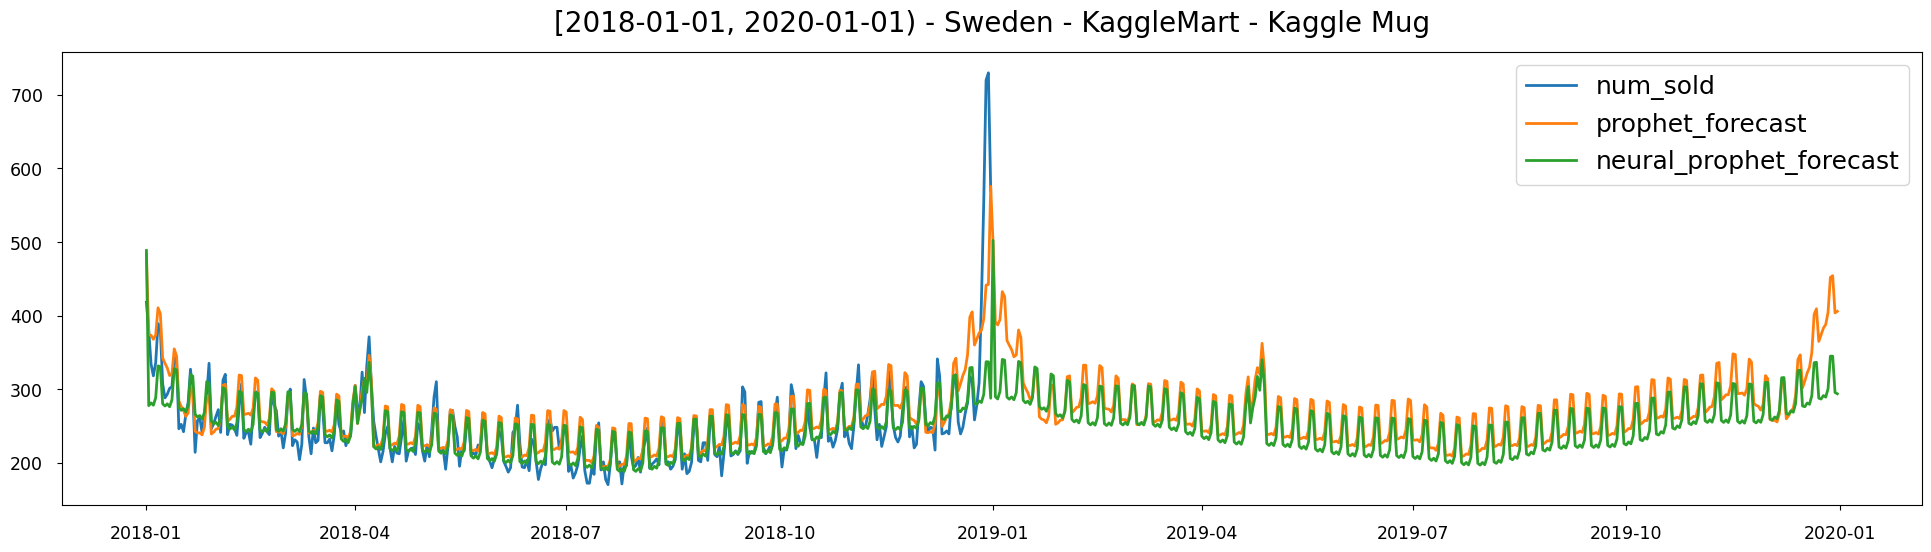

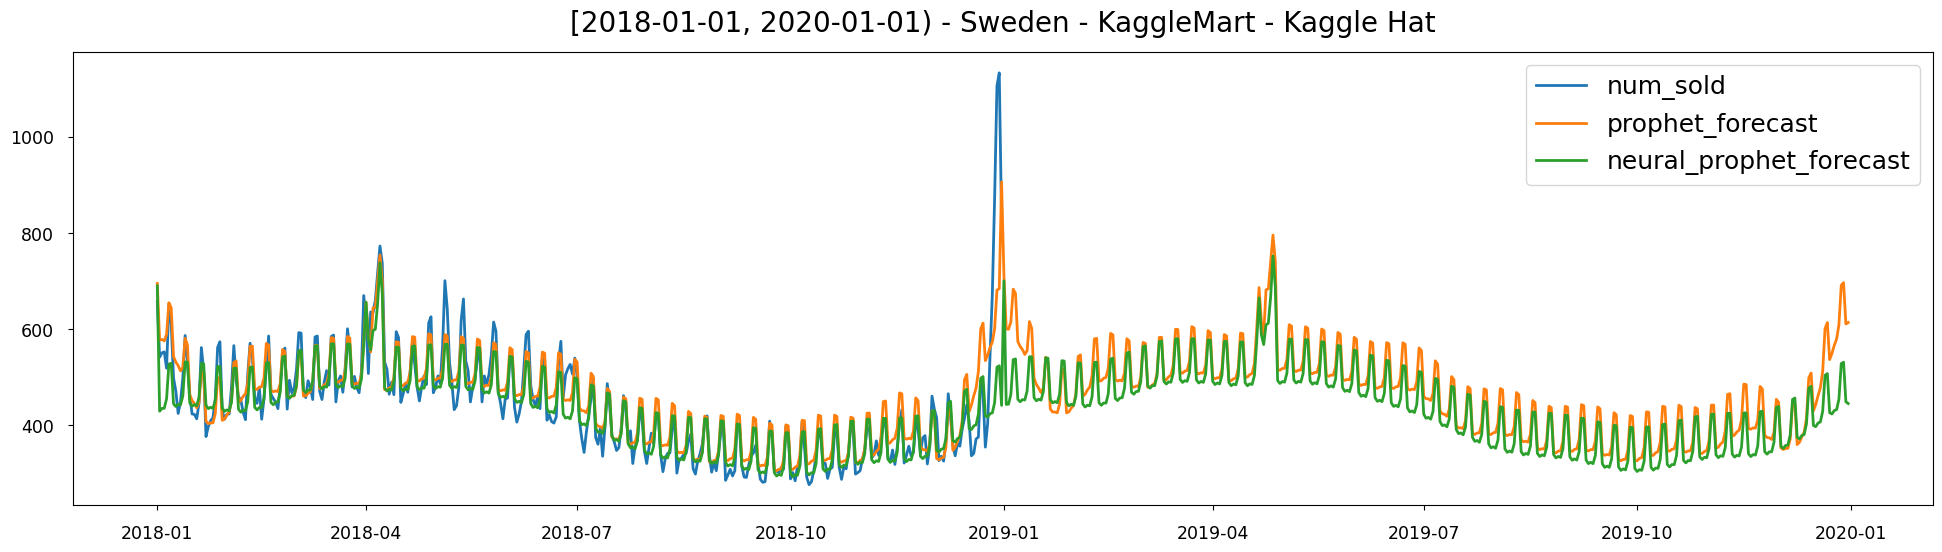

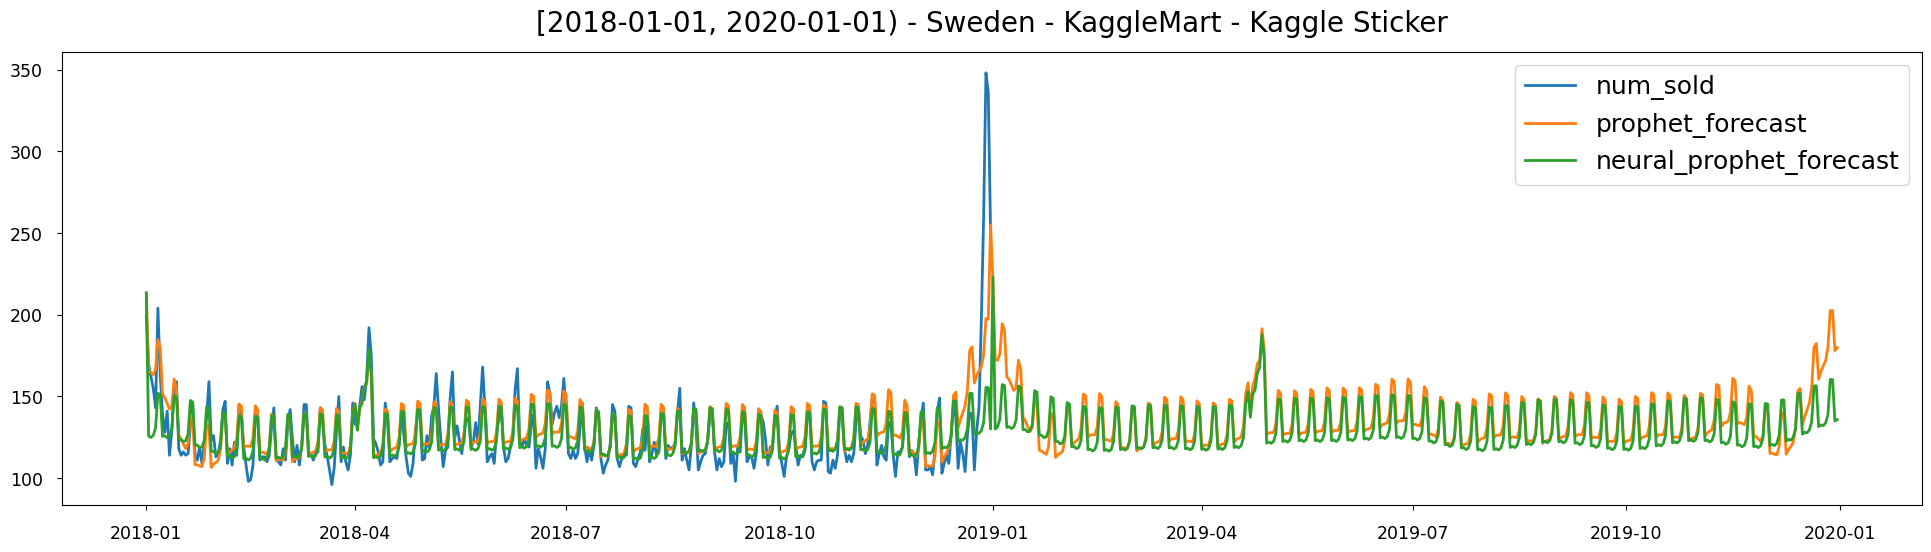

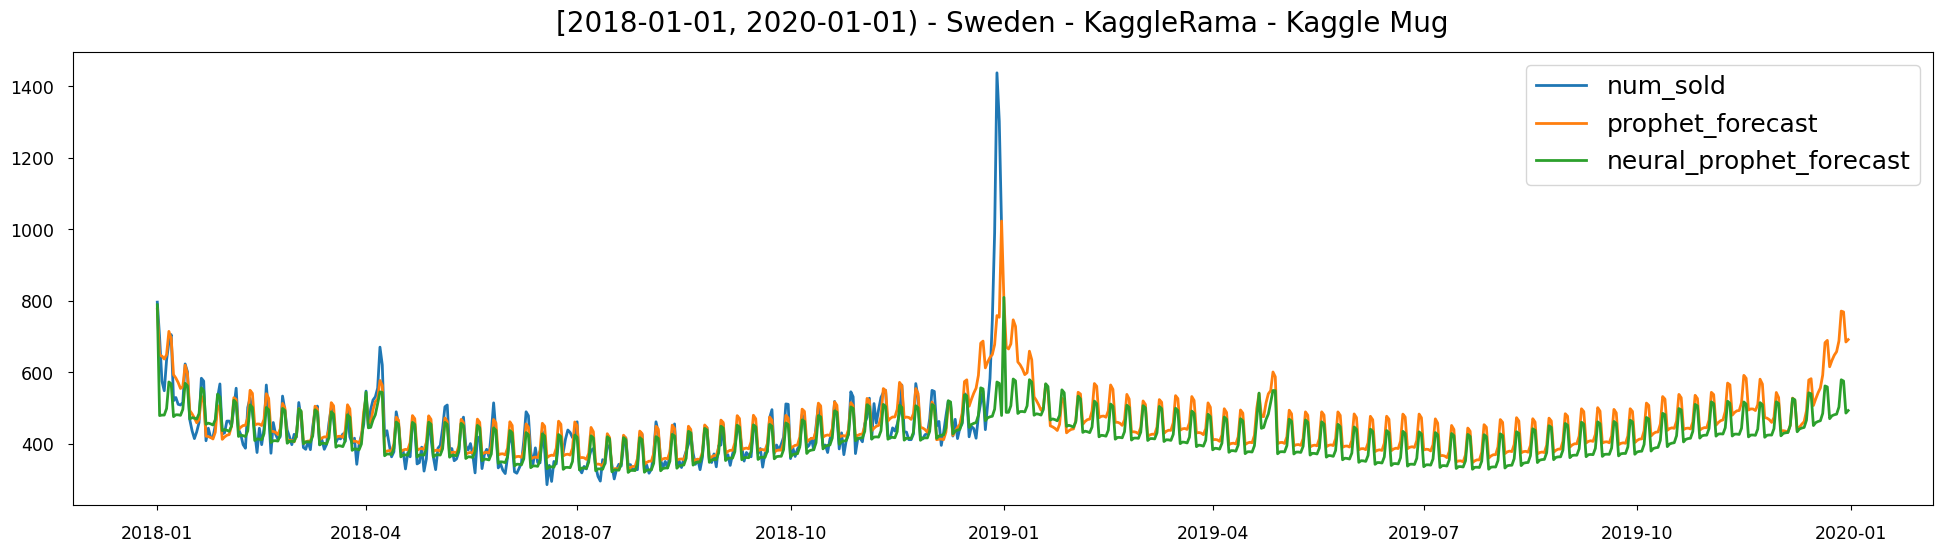

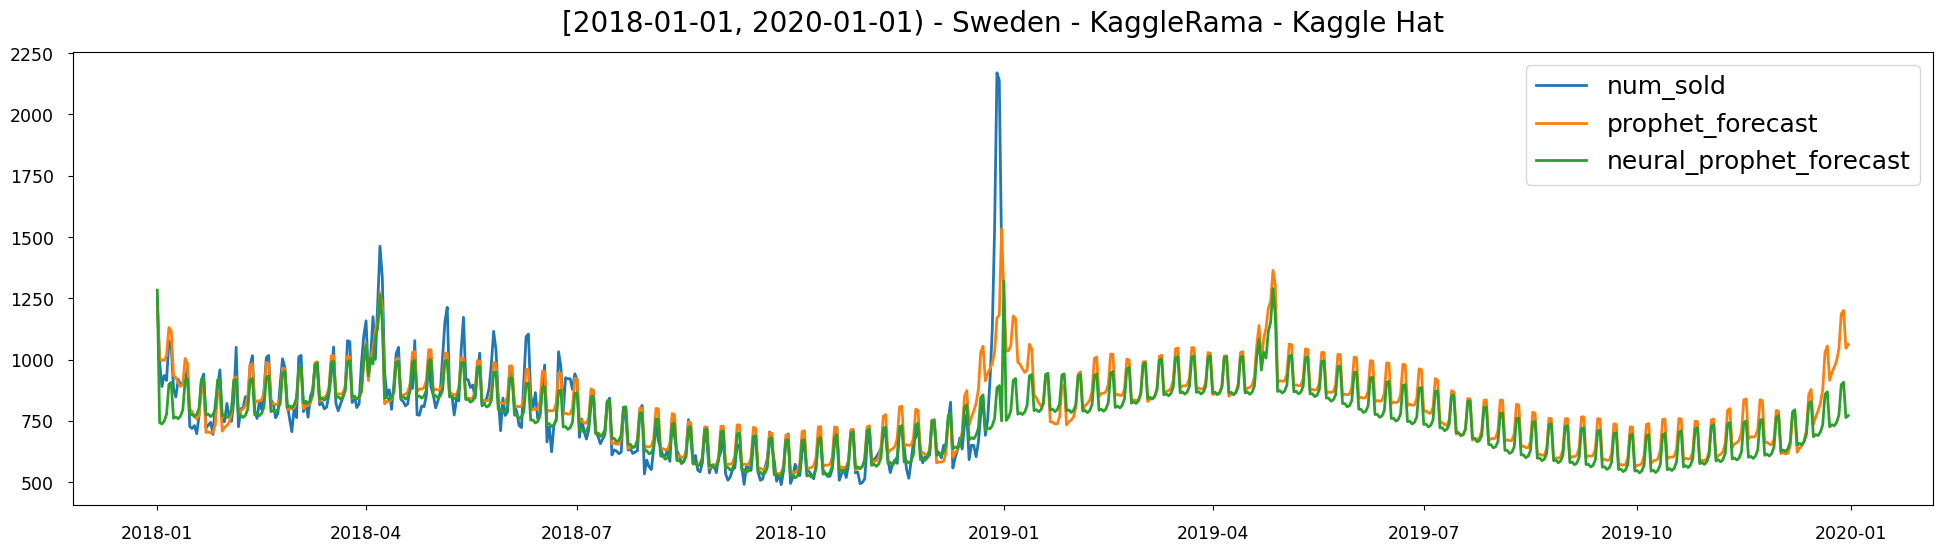

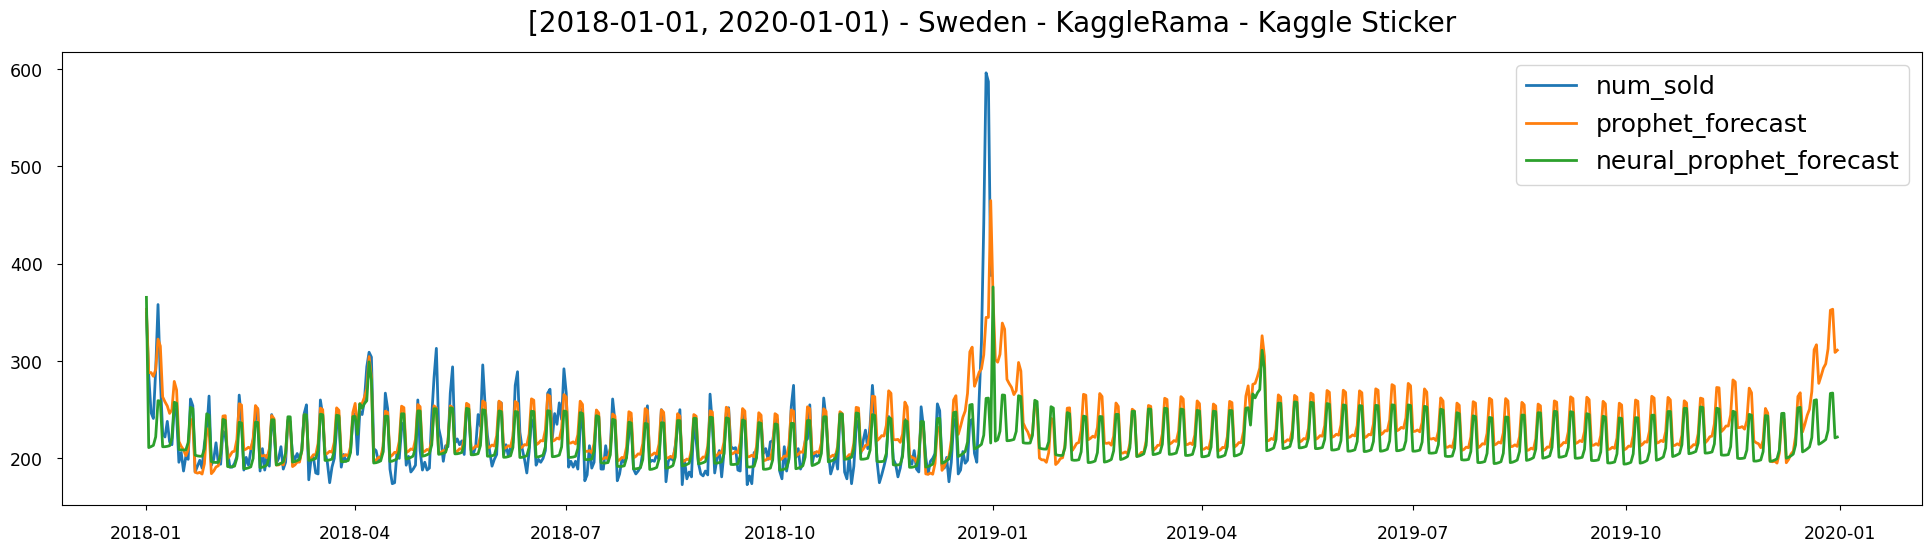

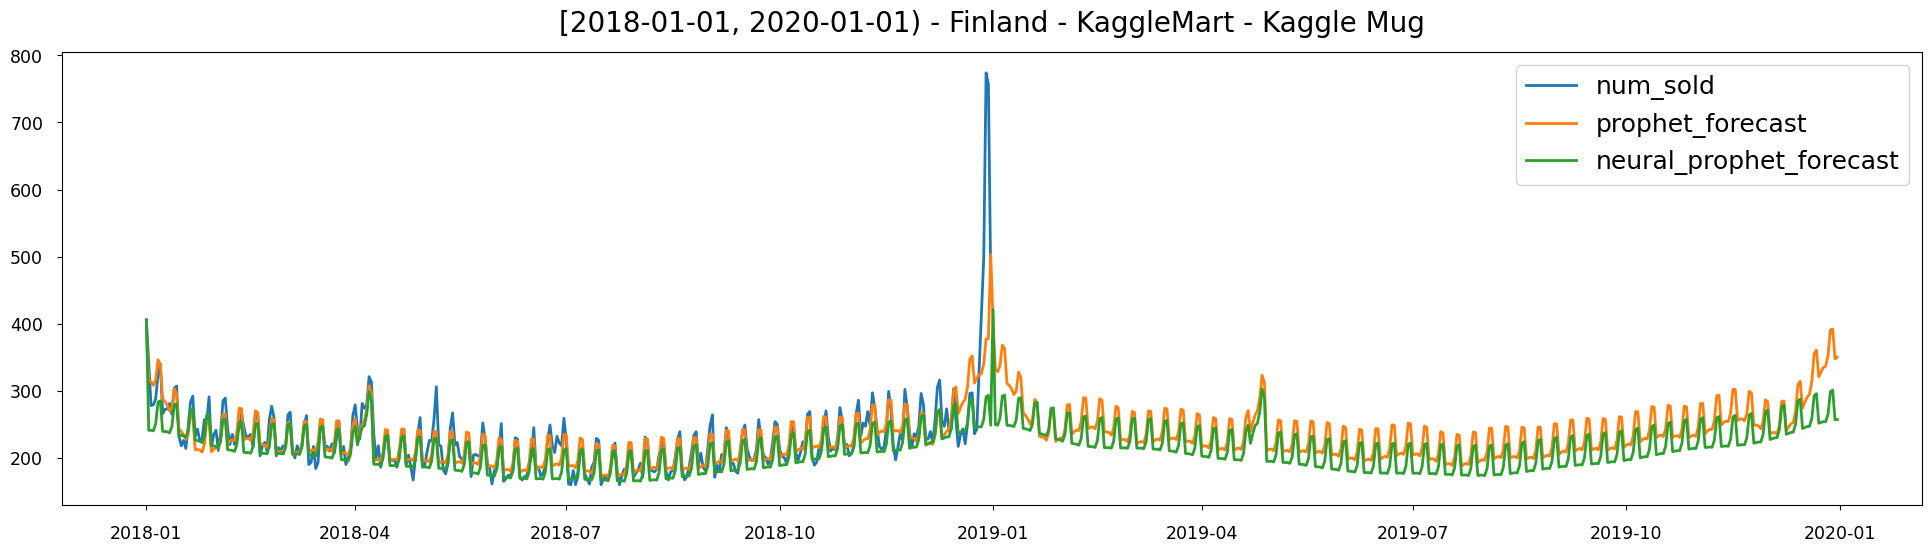

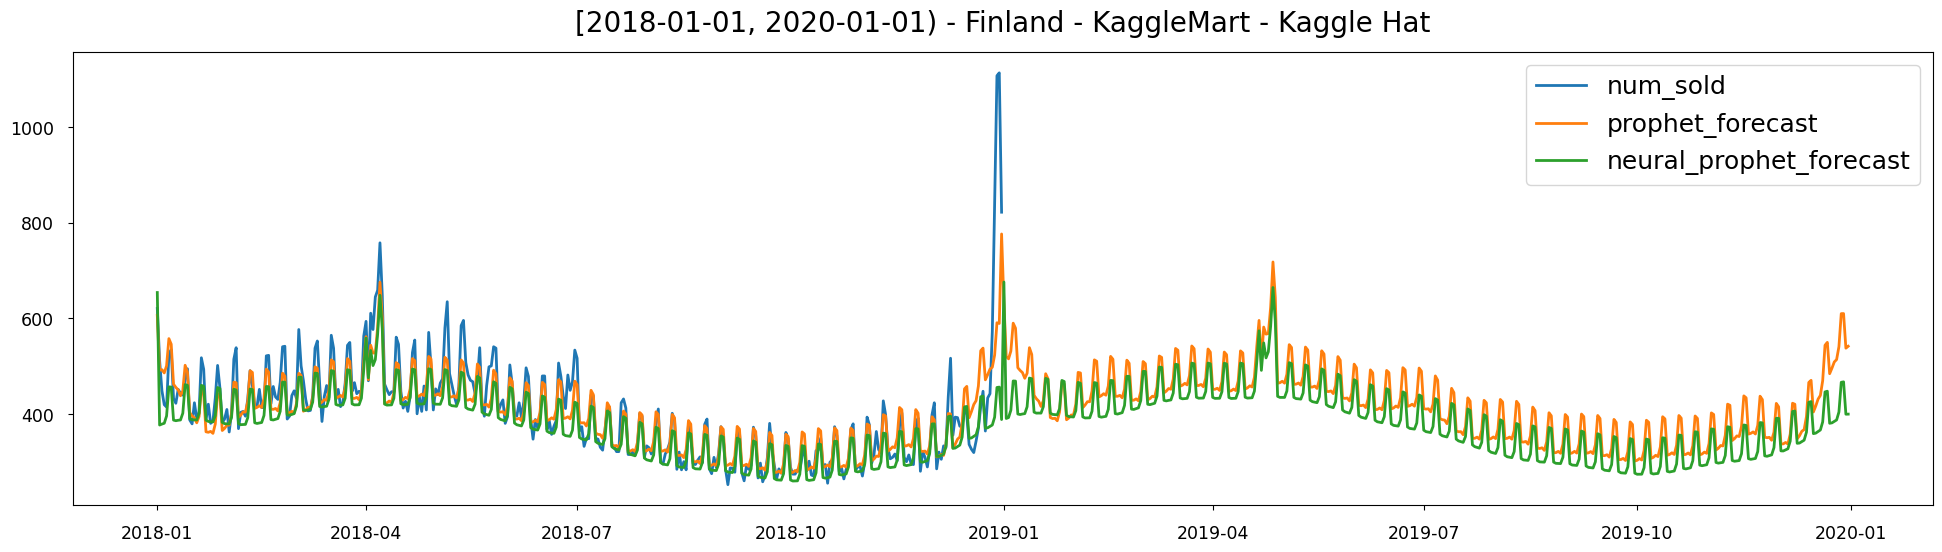

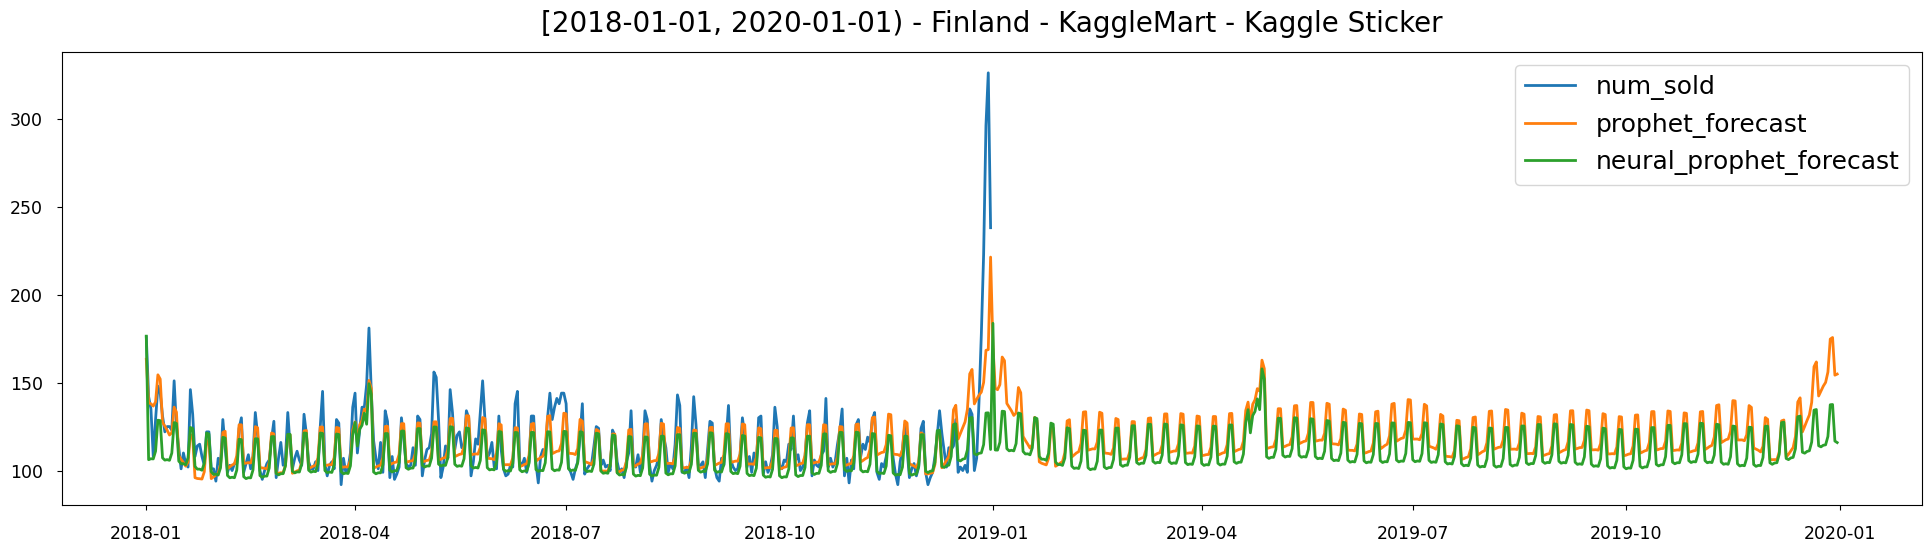

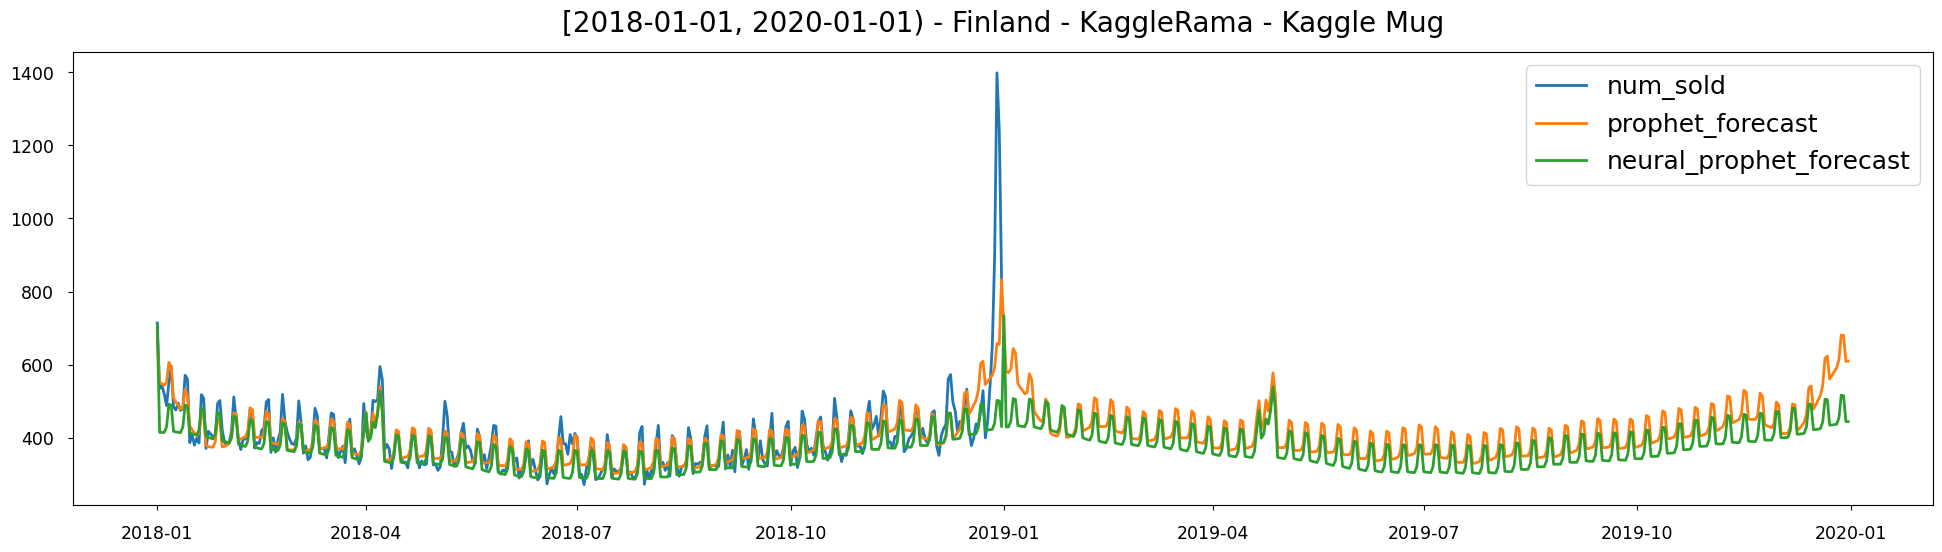

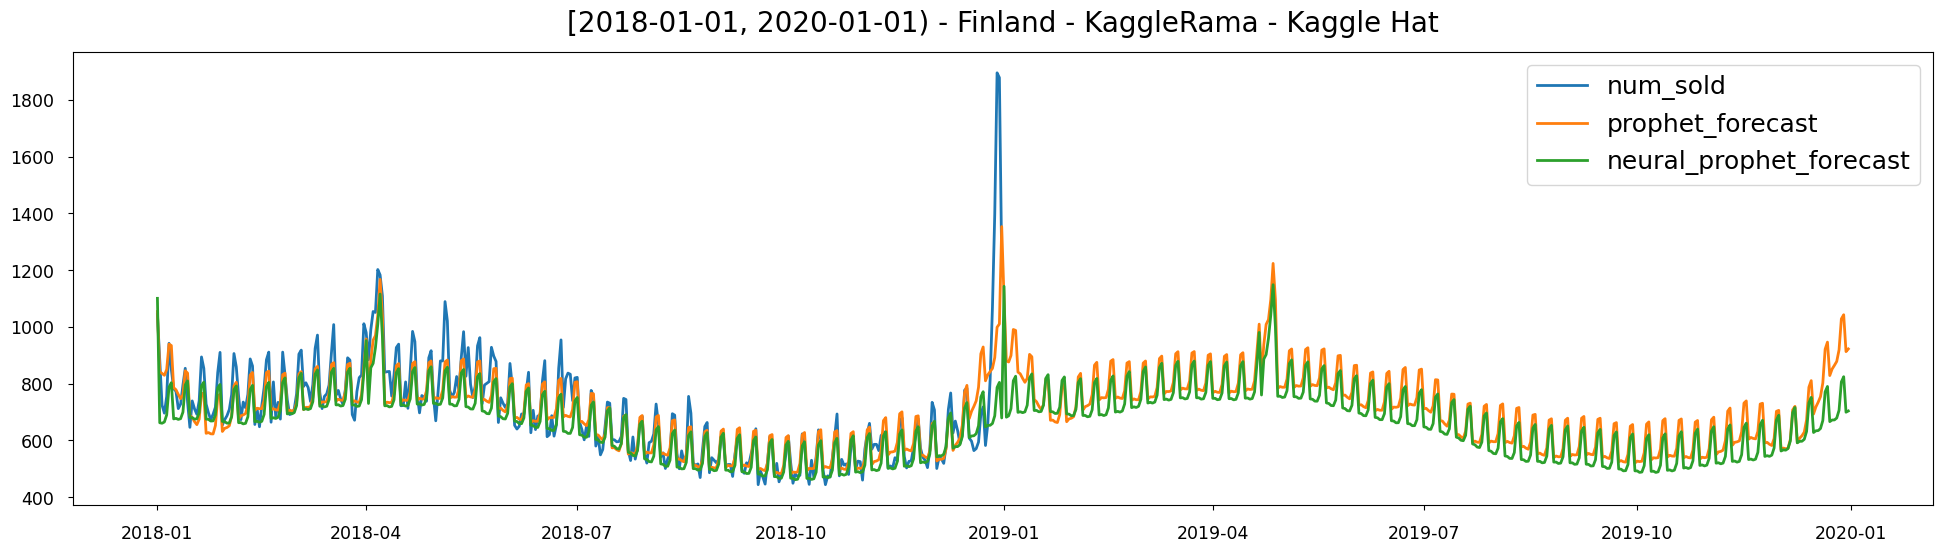

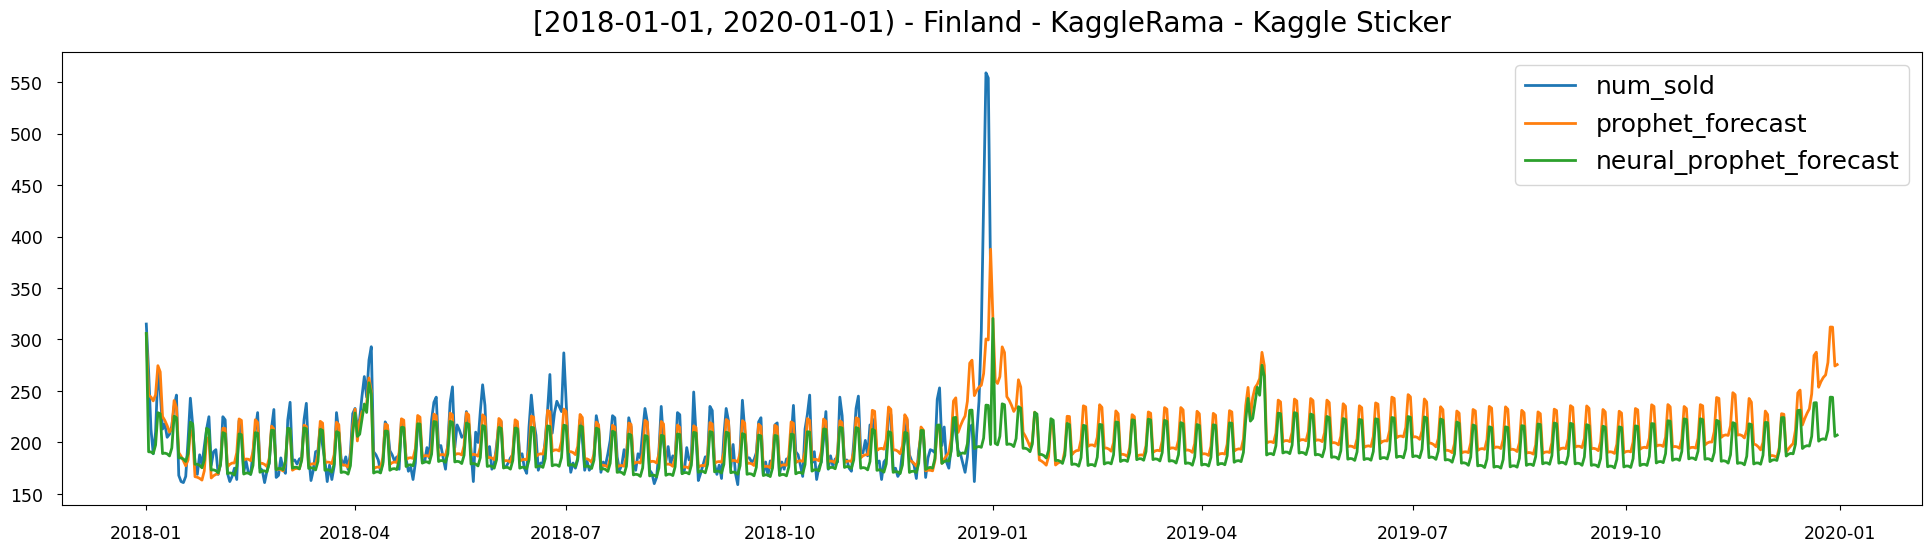

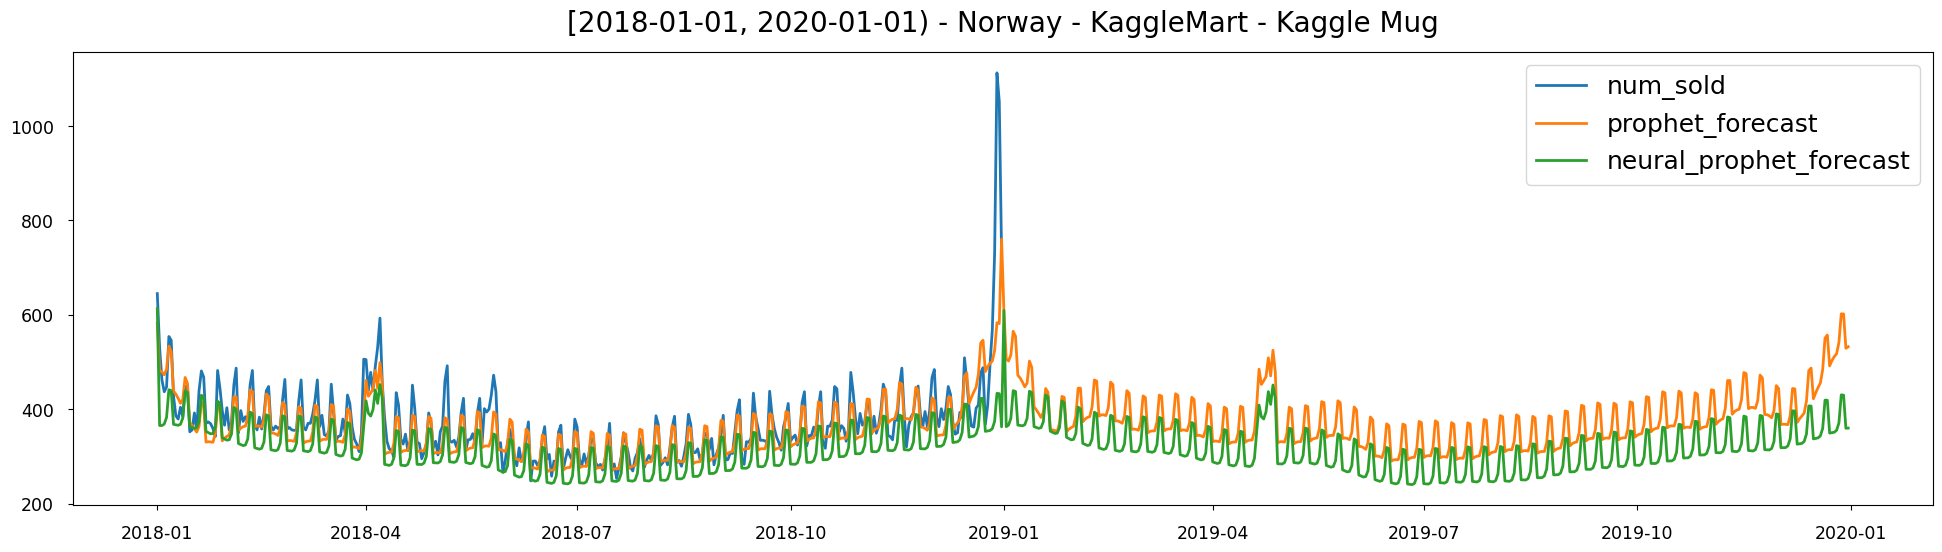

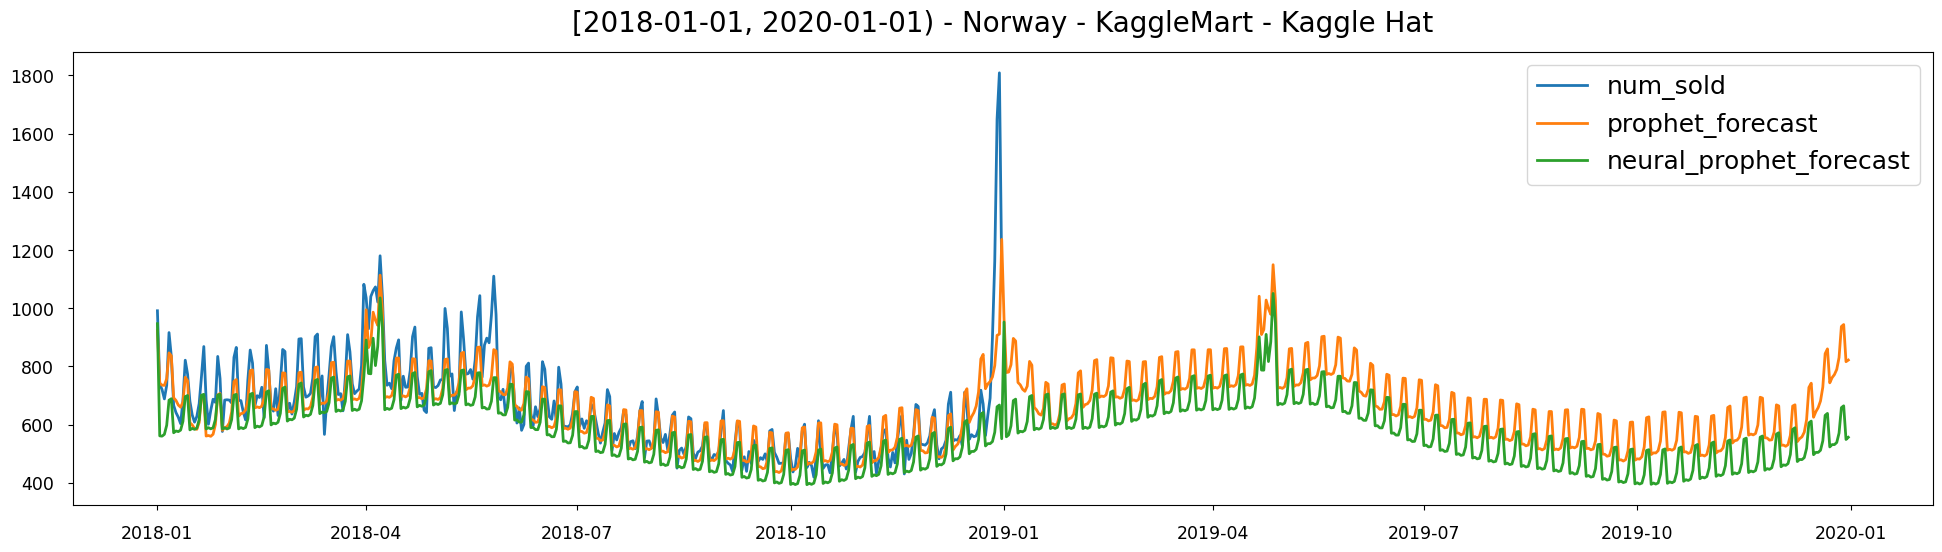

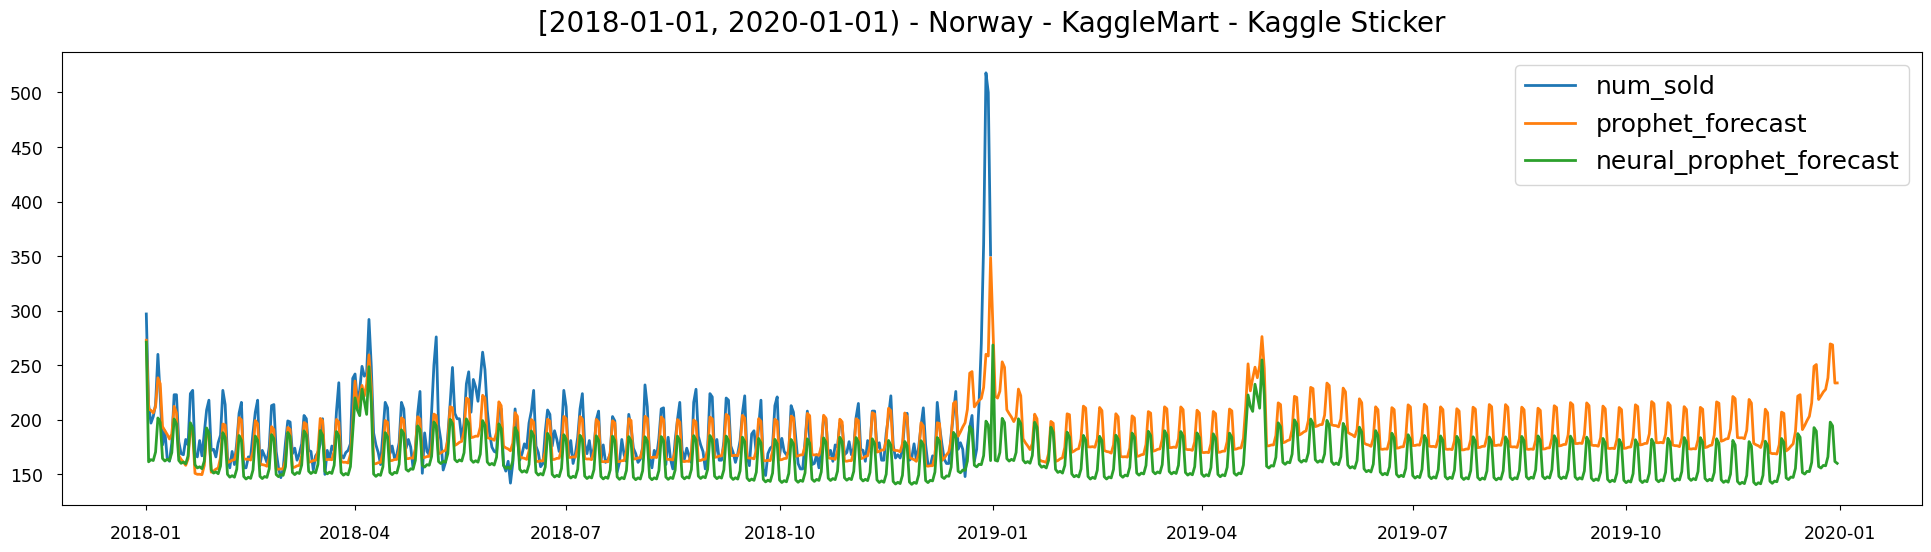

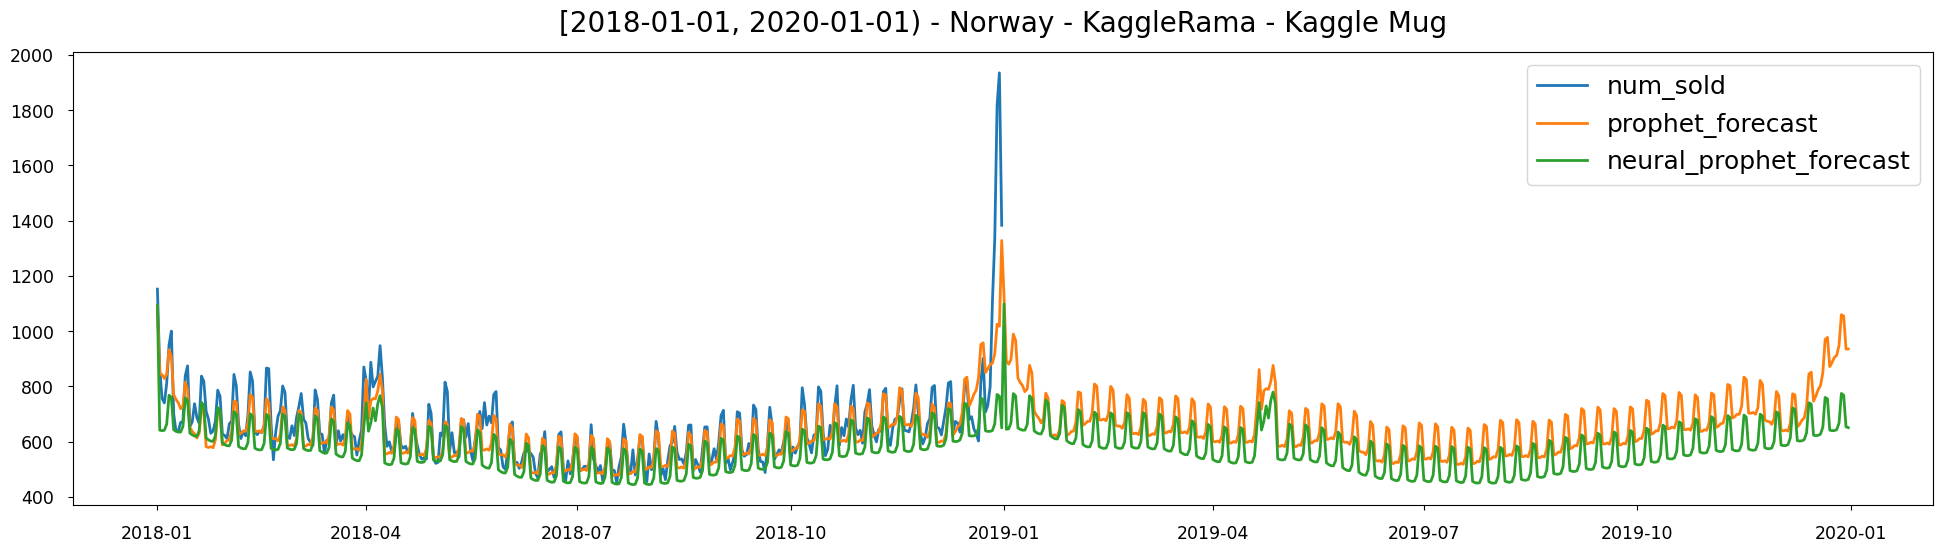

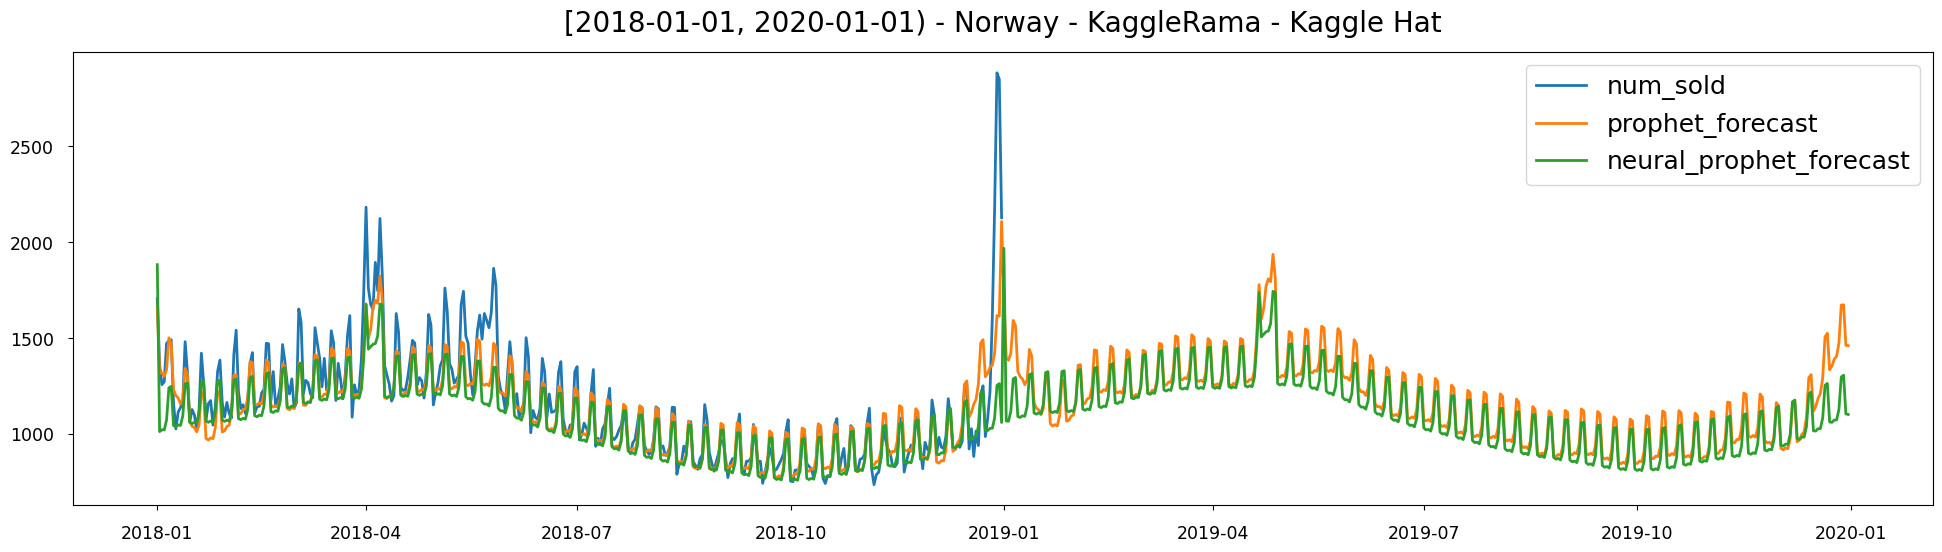

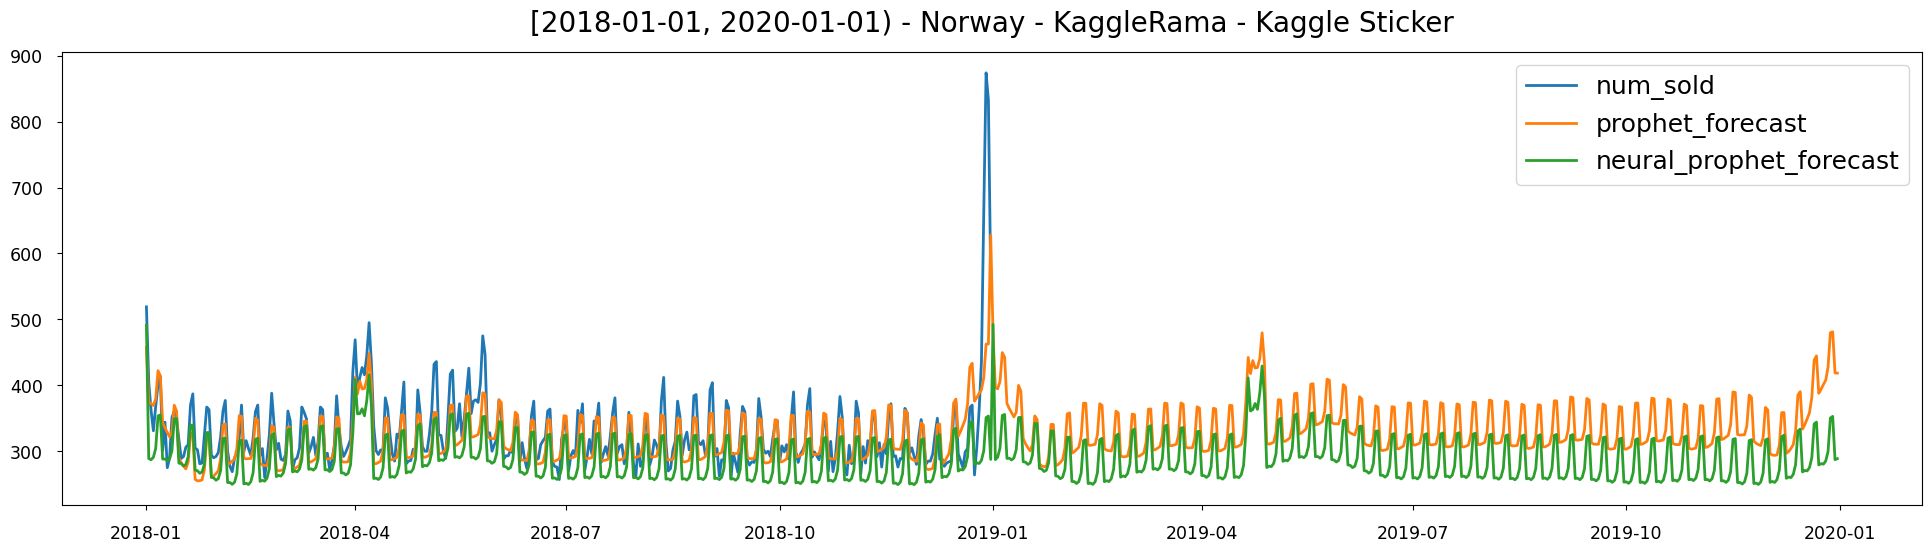

In [10]:
df_all = pd.concat((df_train, df_test), axis=0, ignore_index=True)

for country in countries:
    for store in stores:
        for product in products:
            visualize_ts(
                df=df_all,
                t='date',
                y='num_sold',
                forecasts=['prophet_forecast', 'neural_prophet_forecast'],
                start='2018-01-01',
                end='2020-01-01',
                country=country,
                store=store,
                product=product
            )

## 8. Submission

Test date range is indexed and data is converted to submission format below. Forecast of Prophet and Neural Prophet models are blended and submitted.

In [11]:
test_idx = (df_all['date'] >= '2019-01-01') & (df_all['date'] < '2020-01-01')
df_submission = df_all.loc[test_idx, ['row_id', 'prophet_forecast', 'neural_prophet_forecast']].reset_index(drop=True)
df_submission['num_sold'] = (df_submission['prophet_forecast'] + df_submission['neural_prophet_forecast']) / 2
df_submission[['row_id', 'num_sold']].to_csv('submission.csv', index=False)